# Avocado Price Predictor - hyperparametric executor

RNN + LSTM + GRU

### Python libs and imports

In [ ]:
!pip install numpy pandas tqdm matplotlib plotly scikit-learn tensorflow

In [ ]:
import numpy as np
import pandas as pd

from datetime import datetime

import os
import tqdm

import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Input, Dense, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# create or retrieve the model results_df
def get_model_results_df(model_results_df_name):
    model_results_df_cols = ['model_name', 'model_type', 'avocado_type', 'dense_layers', 'MAE', 'MSE', 'R2', 'loss', 'val_loss', 'y_test', 'y_pred', "epoch_count", "lr_vals", "first_layer_units", "segments"] 

    if os.path.exists(model_results_df_name): # try to load if exists
        with open(model_results_df_name, 'rb') as pkl_file:
            return pickle.load(pkl_file)
    else: # generate a fresh one
        df = pd.DataFrame(columns = model_results_df_cols)
        df.to_pickle(model_results_df_name) # store
        return get_model_results_df(model_results_df_name) # recursive call after save will return the pkl load


# results_df updater
def update_model_results_df(model_results_df_name, new_row):
    results_df = get_model_results_df(model_results_df_name)
    new_row_df = pd.DataFrame(data=[new_row], columns=results_df.columns.to_list())
    
    # updated df
    updated_model_results_df = pd.concat([results_df, new_row_df], ignore_index=True)
    
    #save to pkl on every tick
    updated_model_results_df.to_pickle(model_results_df_name) 


# model callbacks
def get_model_callbacks(path, monitor, model):

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = path,
                                                          monitor = monitor,
                                                          save_best_only = True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = monitor,
                                                      factor = 0.05,
                                                      patience = 7,
                                                      verbose = 0)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = monitor,
                                                      patience = 15,
                                                      verbose = 0,
                                                      start_from_epoch = 40)

    # Custom callback to track and save the LR changes. Triggered on every epoch end.
    lambda_callback_lr_change = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: register_lr_change(epoch, model))

    # return [model_checkpoint, reduce_lr, early_stopping, lambda_callback_lr_change]
    return [reduce_lr, early_stopping, lambda_callback_lr_change]


# custom callback function to handle and track the LR changes in the model fitting. Triggered on every epoch end.
def register_lr_change(epoch, model):
    #current_lr is a global list which is cleared before each model fitting
    current_lr = model.optimizer.lr.numpy()

    #when the LR differs than the previous value, current epoch is saved with the new value
    if current_lr not in lr_vals.values():
        lr_vals[epoch] = current_lr


# preprocess of data
def preprocess_data(data, T):
    X = list()
    y = list()

    for t in range(len(data) - T):

        # append segment
        x = data[t : t + T]
        X.append(x)

        # append next item
        y_ = data[t + T]
        y.append(y_)

    # reshape
    X = np.array(X).reshape(-1, T, 1)
    y = np.array(y)

    return X,y

# dynamic model generator
def generate_model(model_specs):
    #init values
    input_shape = (model_specs["segments"], 1)
    max_dropout = 0.5
    min_dropout = 0.1
    return_sequences = True

    
    model = Sequential() #always Sequential
    
    # dynamic type received
    if model_specs["type"] == "RNN":
        model.add(Input(shape = input_shape)) # RNN input layer
        model.add(SimpleRNN(units = model_specs["type_units"], activation = "relu")) #RNN layer
    elif model_specs["type"] == "LSTM":
        model.add(LSTM(units=model_specs["type_units"], return_sequences=return_sequences, input_shape=input_shape))
        model.add(Dropout(max_dropout)) # dropout for LSTM
    elif model_specs["type"] == "GRU":
        model.add(GRU(units=model_specs["type_units"], return_sequences=return_sequences, input_shape=input_shape, activation='tanh'))
        model.add(Dropout(max_dropout)) # dropout for GRU
    else:
        raise Exception("type not compatible")

    # dropout value calc vars #
    current_dl_layer = 0
    total_dense_layers = sum([x[0] for x in model_specs["dense_layers"]])
    step_dropout_val = 0.0 # dropout value on each step
    step_unit = ( max_dropout - min_dropout ) / ( total_dense_layers - 2) # dropout gain or loss on each step
    

    # dense layers generation following the received specification
    for dense_layer in model_specs["dense_layers"]:
        for i in range(dense_layer[0]): # dense_layer[0] is the number of dense layers with an specific unit
            current_dl_layer += 1
            next_layer = None

            # for the last LSTM/GRU layer, return_sequences is False and input_shape is None
            if current_dl_layer == total_dense_layers:
                return_sequences = False
                if model_specs["type"] == "LSTM":
                    next_layer = LSTM(units=dl_units, return_sequences=return_sequences)
                elif model_specs["type"] == "GRU":
                    next_layer = GRU(units=dl_units, return_sequences=return_sequences, input_shape=input_shape, activation='tanh')
                

            # calc dropout for LSTM/GRU
            if model_specs["type"] == "LSTM":
                # LSTM: dropout starts from min to max, ascending on each layer step
                dropout_val = min_dropout + (current_dl_layer / (total_dense_layers)) * (max_dropout - min_dropout)
                dropout_val = round(dropout_val,1) # round 1 decimal
            elif model_specs["type"] == "GRU":
                # GRU: dropout starts on max_dropout-0.1, decreases and then increases again
                if current_dl_layer == 1 or current_dl_layer == total_dense_layers:
                    # first and last layers set max_dropout-0.1
                    step_dropout_val = max_dropout-0.1
                else:
                    if current_dl_layer <= ( total_dense_layers // 2 + 1.3 ): # 1.3 is a custom offset
                        # first half (+1.3), decreases
                        step_dropout_val = step_dropout_val - step_unit
                    else:
                        # second half, increases
                        step_dropout_val = step_dropout_val + (step_unit * 1.3) # 1.3 is a custom offset

                dropout_val = round(step_dropout_val, 1) # round to 1 decimal

            dl_units = dense_layer[1] # dense_layer[1] is the units value

            if next_layer:
                model.add(next_layer) # when is the last one without input_shape
            elif model_specs["type"] == "RNN":
                model.add(Dense(units=dl_units, activation="relu"))
            elif model_specs["type"] == "LSTM":
                model.add(LSTM(units=dl_units, return_sequences=return_sequences, input_shape=input_shape)) # + return_sequences and input_shape
            elif model_specs["type"] == "GRU":
                model.add(GRU(units=dl_units, return_sequences=return_sequences, input_shape=input_shape, activation='tanh')) # + return_sequences and input_shape
                
            if model_specs["type"] in ["GRU", "LSTM"]: #GRU/LSTM add Dropout
                model.add(Dropout(dropout_val))
                

    #last layer should be units=1 because of the model ( time series forecast )
    model.add(Dense(units=1))

    return model


# model executor
def execute_models(data_df, model_specs, model_results_df_name, offset = False):
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #disable logging
    
    # init some count vars for the offset
    type_steps = -1
    steps = -1
    
    # set the iterator
    ms_iterator = model_specs
    
    types = data_df["Type"].unique() #get the different types
    for c_type in types:
        type_steps += 1
        c_type_data_df = data_df.copy()
        c_type_data_df = c_type_data_df[c_type_data_df['Type'] == c_type].sort_values("Date", ascending = True) #select only the current type, resort by date
        c_type_data_df = c_type_data_df.groupby('Date')['Average Price'].mean().reset_index(drop = True) #final data is avg price per date

        # offset allows the partial execution if the previous one fails or stop early
        if offset and type_steps in offset.keys():
            offset_value = offset[type_steps]
            ms_iterator = model_specs[offset_value:]
            print(f"OFFSET: Jumping to model_specs[{offset_value}:]")
        else:
            ms_iterator = model_specs

        # iterate over each model_spec received
        for model_spec in tqdm.tqdm(ms_iterator):

            #set default specs values for missing configuration
            if "segments" not in model_spec.keys():
                model_spec["segments"] = 10 # T=10 as default
            if "epoch" not in model_spec.keys():
                model_spec["epochs"] = 200 # 200 epochs as default

            #perform the preprocess of data
            X,y = preprocess_data(c_type_data_df, model_spec["segments"])

            #Train Test Split, lineal 80/20, con el parámetro de shuffle = False, se quita la aleatoriedad del split train-test
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = False)

            # total_dense_layers = sum([x[0] for x in model_spec["dense_layers"]]) # debug
            # print(f"type: {model_spec['type']} - dense_layers: {total_dense_layers} - type_units: {model_spec['type_units']} - segments: {model_spec['segments']}")
            
            #model generation
            model = generate_model(model_spec)
            model.compile(optimizer = "adam", loss = "mse") #se compila el modelo con el optimizador Adam
            # model.summary() # comment for quiet mode

            #generate unique name for the model backup file
            now = datetime.now()
            timestamp = now.strftime("%Y%m%d%H%M%S")
            model_name_path = f'models/model_trained_{c_type}_{model_spec["type"]}_{timestamp}.keras'

            # get model callbacks
            callbacks = get_model_callbacks(model_name_path, 'val_loss', model)

            # train process
            lr_vals.clear() # global list used for LR change tracking should be cleared before the train
            history = model.fit(x = X_train,
                                y = y_train,
                                validation_data = (X_test, y_test),
                                epochs = model_spec["epochs"],
                                callbacks = callbacks,
                                verbose = False)
                          
            # trigger the prediction
            y_pred = model.predict(X_test)
            y_pred = y_pred[:, 0]

            # get model stats
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # save stats to the results df
            results_list = [
                model_name_path,
                model_spec["type"],
                c_type,
                model_spec["dense_layers"],
                mae,
                mse,
                r2,
                history.history["loss"],
                history.history["val_loss"],
                y_test,
                y_pred,
                max(history.epoch),
                lr_vals,
                model_spec["type_units"],
                model_spec["segments"]
            ]

            # update model results with the results
            update_model_results_df(model_results_df_name, results_list)


# generates a list of different models specs for testing and experimentation, depending on the configuration and values setted
def get_model_specs():
    # dense_layers list, first value is the number of layers and second one is the value
    dense_layers_list = [
        [
            [5, 256],
            [3, 128],
            [2, 64],
            [1, 32],
            [1, 16],
        ],
        [
            [2, 512],
            [2, 256],
            [2, 128],
            [2, 64],
            [1, 32],
            [1, 16],
        ],
        [
            [1, 1024],
            [1, 512],
            [1, 256],
            [1, 128],
            [1, 64],
            [1, 32],
            [1, 16],
        ],
        [
            [1, 2048],
            [1, 1024],
            [1, 512],
            [1, 256],
            [1, 128],
            [1, 64],
            [1, 32],
            [1, 16],
        ],
        [
            [1, 4096],
            [1, 2048],
            [1, 1024],
            [1, 512],
            [1, 256],
            [1, 128],
            [1, 64],
            [1, 32],
            [1, 16],
        ]
    ]

    model_specs = [] # list to save specs

    model_types = ["RNN", "LSTM", "GRU"]
    
    for t in model_types:
        for n in range(40,200,20): # first layer unit
            for s in range(6,16,2): # segments
                for dense_layers in dense_layers_list:
                    model_spec = {
                        "type": t,
                        "type_units": n, # units value for the first layer
                        "segments": s,
                        "epochs": 200,
                        "dense_layers": dense_layers
                    }
                    model_specs.append(model_spec)

    return model_specs

## EXECUTION PROCESS

In [3]:
# global configuration
lr_vals = {} # global dict to save LR changes, used by a callback

# df to store the model performace stats, one file per day
model_results_df_name = f'model_results_df_{datetime.now().strftime("%Y%m%d")}.pkl'
model_results_df = get_model_results_df(model_results_df_name)

# load data df
avocado_data_pkl = "Data/avocado_dataset_preprocessed.pkl"

if os.path.exists(avocado_data_pkl):
    with open(avocado_data_pkl, 'rb') as pkl_file:
        data_df = pickle.load(pkl_file)

# get the list of models and its specs to be launched
model_specs = get_model_specs()

In [4]:
len(model_specs)

600

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51933 entries, 0 to 51932
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Region             51933 non-null  object 
 1   Timeframe          51933 non-null  object 
 2   Date               51933 non-null  object 
 3   Type               51933 non-null  object 
 4   Average Price      51933 non-null  float64
 5   Total Volume       51933 non-null  float64
 6   4046 Units         51933 non-null  float64
 7   4225 Units         51933 non-null  float64
 8   4770 Units         51933 non-null  float64
 9   TotalBagged Units  51933 non-null  float64
 10  SmlBagged Units    27861 non-null  float64
 11  LrgBagged Units    27861 non-null  float64
 12  X-LrgBagged Units  27861 non-null  float64
 13  Year               51933 non-null  int64  
dtypes: float64(9), int64(1), object(4)
memory usage: 5.5+ MB


### EXECUTOR

In [ ]:
# HEAVY PROCESS! YOU CAN AVOID THE EXECUTION AND JUST TAKE A DATAFRAME WITH 1200 MODELS EXECUTION DETAILS IN THE NEXT PARTS

# execute the list of models for the current df
# execute_models(data_df=data_df, model_specs=model_specs, model_results_df_name=model_results_df_name)

## RESULTS

In [7]:
# graph the statistics (loss/val_loss + forecast + ratios + specs) of the models' performance
def get_results(data):
    for idx,row in data.iterrows():
        fig, axes = plt.subplots(1, 2, figsize = (20, 10))
        model_name = row["model_name"]
        fig.suptitle(f"MODEL: {model_name}",x=0.05, y=0.95, fontsize=18, ha="left")
        axes[0].plot(row["loss"], label = "loss")
        axes[0].plot(row["val_loss"], label = "val_loss")
        axes[0].legend()

        axes[1].plot(row["y_test"], label = "forecast target")
        axes[1].plot(row["y_pred"], label = "forecast prediction")
        axes[1].legend()

        # additional info: ratios + dense layers count, lr changes, epochs
        total_dense_layers = sum([x[0] for x in row["dense_layers"]])
        info_text = [
            f"=Metrics=",
            f"MAE: {row['MAE']:.4f}",
            f"MSE: {row['MSE']:.4f}",
            f"R2: {row['R2']:.4f}",
            f"",
            f"=Config=",
            f"Model Type: {row['model_type']}",
            f"Dense Layers: {total_dense_layers}",
            f"LR Variations: {len(row['lr_vals'])}",
            f"Epochs: {row['epoch_count']}",
            f"Segments: {row['segments']}",
            f"1st layer units: {row['first_layer_units']}",
        ]

        info_text = '\n'.join(info_text)
        fig.text(0.98, 0.98, info_text, fontsize=11, ha="right", va="top")
        print(f"MODEL: {model_name}")
        plt.show()

### DataFrame of performance results

In [8]:
model_results_df = get_model_results_df(model_results_df_name)

# uncomment to run with saved data
all_models_df_name = "Data/all_models_full_df.pkl"
if os.path.exists(all_models_df_name):
        with open(all_models_df_name, 'rb') as pkl_file:
            model_results_df = pickle.load(pkl_file)

model_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   model_name         1202 non-null   object        
 1   model_type         1202 non-null   object        
 2   avocado_type       1202 non-null   object        
 3   dense_layers       1202 non-null   object        
 4   MAE                1202 non-null   float64       
 5   MSE                1202 non-null   float64       
 6   R2                 1202 non-null   float64       
 7   loss               1202 non-null   object        
 8   val_loss           1202 non-null   object        
 9   y_test             1202 non-null   object        
 10  y_pred             1202 non-null   object        
 11  epoch_count        1202 non-null   object        
 12  lr_vals            1202 non-null   object        
 13  first_layer_units  1202 non-null   object        
 14  segments

/tmp/ipykernel_61568/349928313.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  model_results_df = pickle.load(pkl_file)


### TOP 3 R2 scores

In [9]:
avocado_types = model_results_df["avocado_type"].unique()
model_types = model_results_df["model_type"].unique()

for model_type in model_types:
    print()
    print(f"Results for {model_type}")
    data = model_results_df[model_results_df["model_type"] == model_type]
    for avocado_type in avocado_types:
        print(f"AVOCADO TYPE: {avocado_type}")
        filtered_data = data[data["avocado_type"] == avocado_type]
        filtered_data = filtered_data.sort_values("R2", ascending = False).head(3)
        for idx,row in filtered_data.iterrows():
            total_dense_layers = sum([x[0] for x in row["dense_layers"]])
            info_text = f"R2: {row['R2']:.4f} / {row['model_name']} / MAE: {row['MAE']:.4f} / MSE: {row['MSE']:.4f}"
            print(info_text)


Results for RNN
AVOCADO TYPE: Conventional
R2: 0.9331 / models/model_trained_Conventional_RNN_20240109143325.keras / MAE: 0.0311 / MSE: 0.0018
R2: 0.9326 / models/model_trained_Conventional_RNN_20240109133626.keras / MAE: 0.0312 / MSE: 0.0018
R2: 0.9325 / models/model_trained_Conventional_RNN_20240109144358.keras / MAE: 0.0318 / MSE: 0.0018
AVOCADO TYPE: Organic
R2: 0.9510 / models/model_trained_Organic_RNN_20240109182402.keras / MAE: 0.0297 / MSE: 0.0015
R2: 0.9505 / models/model_trained_Organic_RNN_20240109183146.keras / MAE: 0.0289 / MSE: 0.0015
R2: 0.9499 / models/model_trained_Organic_RNN_20240109181642.keras / MAE: 0.0301 / MSE: 0.0015

Results for GRU
AVOCADO TYPE: Conventional
R2: 0.7936 / models/model_trained_Conventional_GRU_20240109135526.keras / MAE: 0.0552 / MSE: 0.0056
R2: 0.7757 / models/model_trained_Conventional_GRU_20240109142208.keras / MAE: 0.0566 / MSE: 0.0061
R2: 0.7442 / models/model_trained_Conventional_GRU_20240109163021.keras / MAE: 0.0603 / MSE: 0.0070
AVOCA

### Best models performance


Results for RNN
AVOCADO TYPE: Conventional
MODEL: models/model_trained_Conventional_RNN_20240109143325.keras


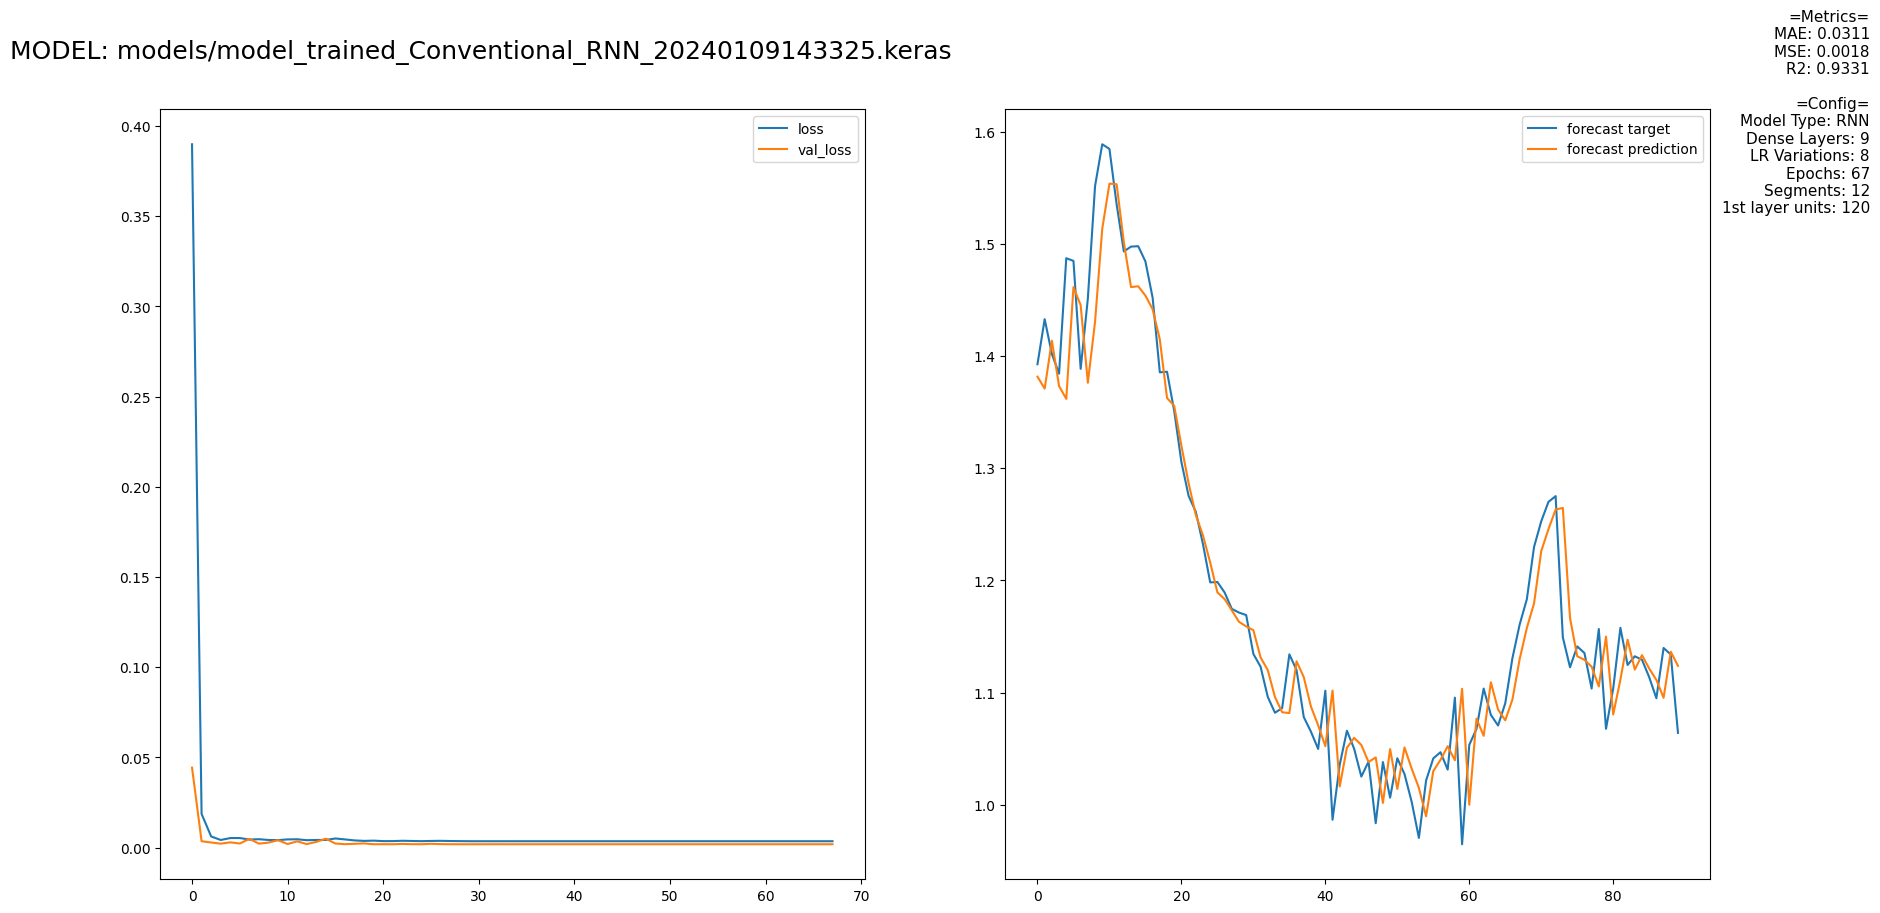

MODEL: models/model_trained_Conventional_RNN_20240109133626.keras


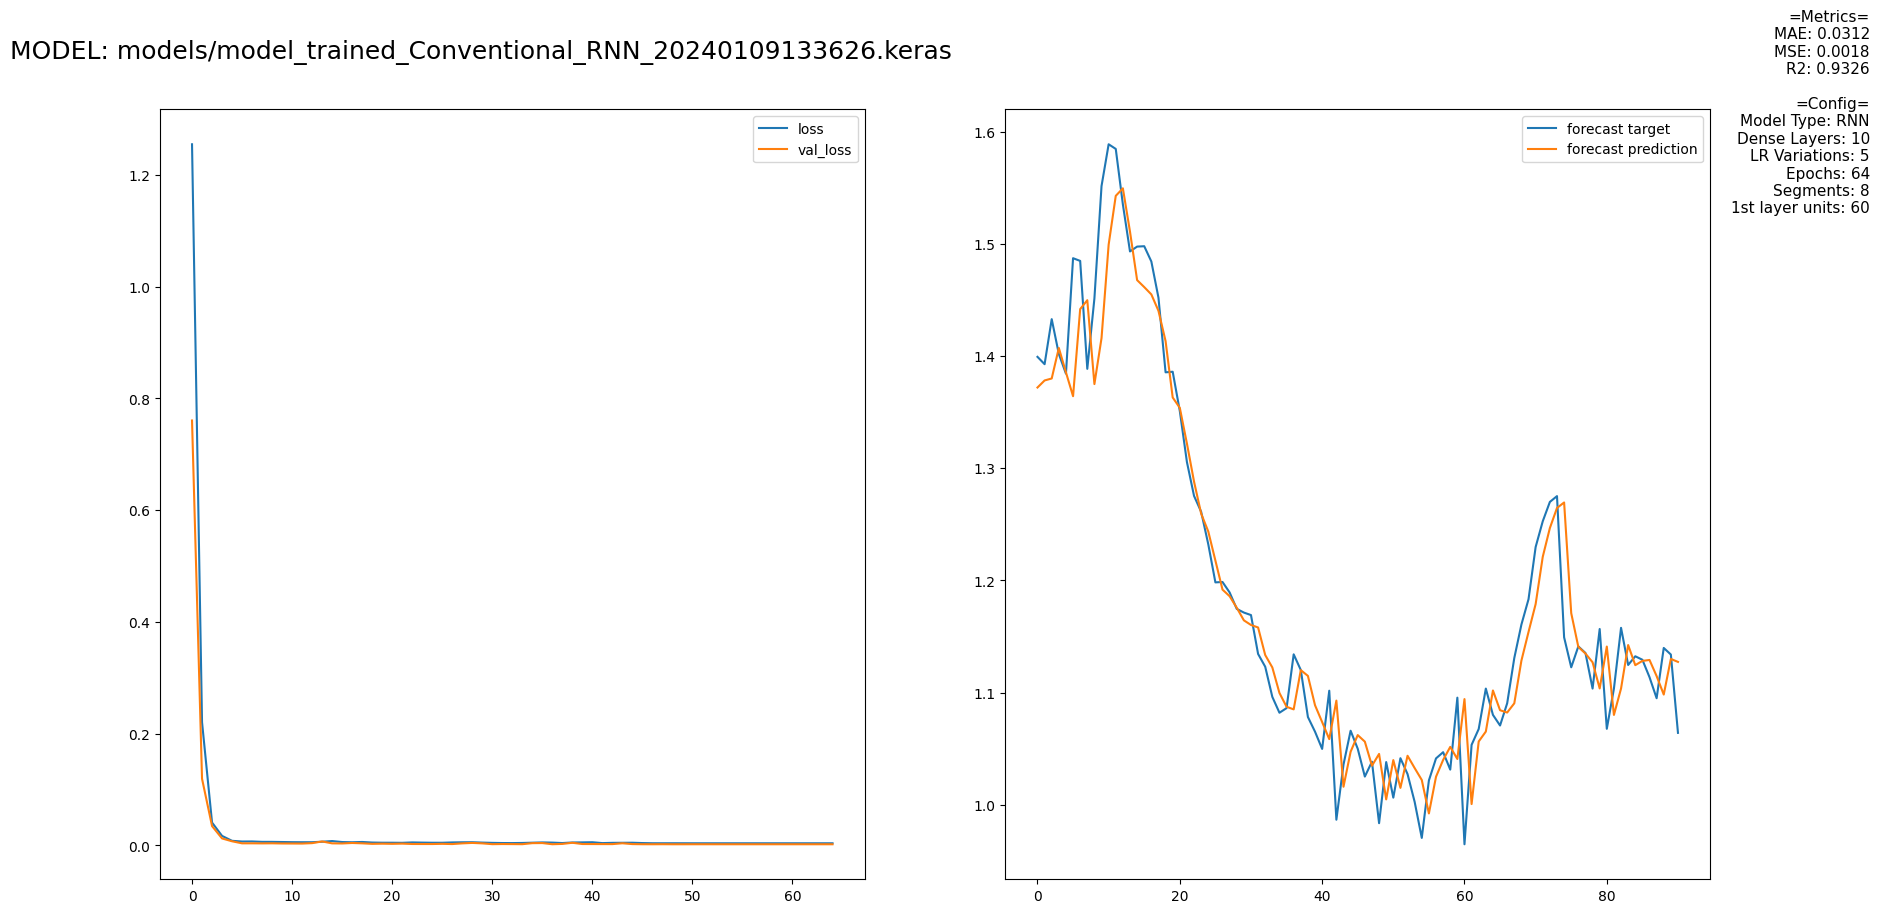

MODEL: models/model_trained_Conventional_RNN_20240109144358.keras


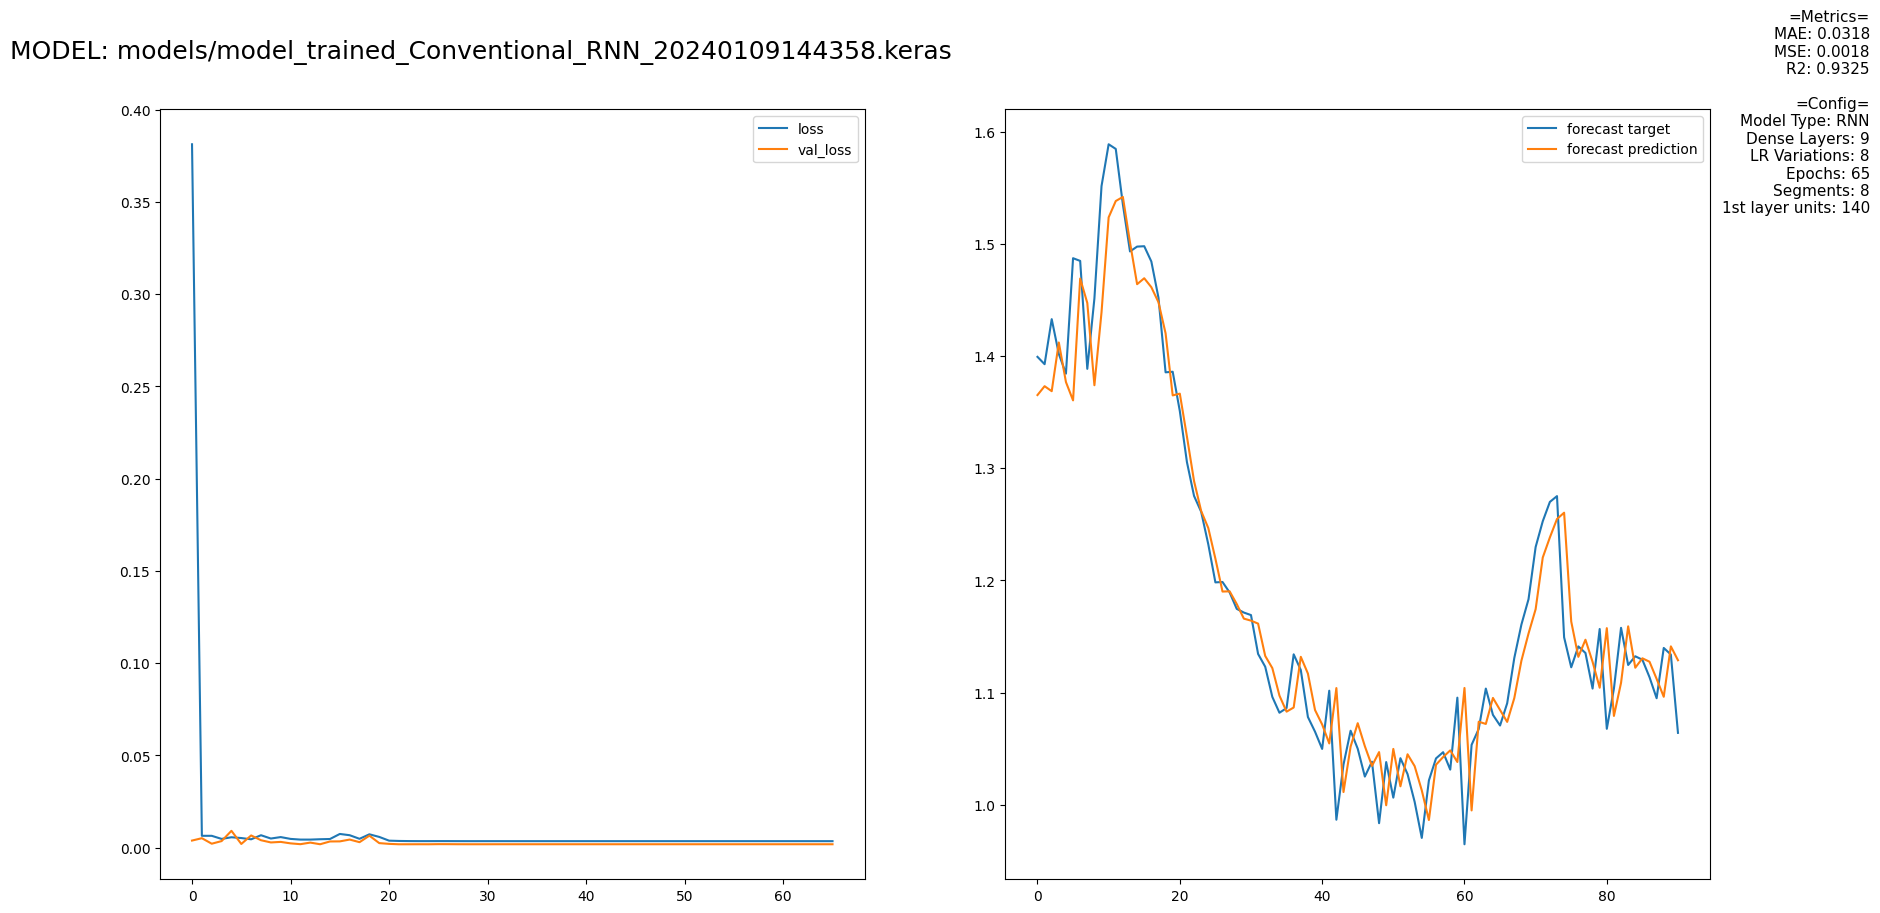

AVOCADO TYPE: Organic
MODEL: models/model_trained_Organic_RNN_20240109182402.keras


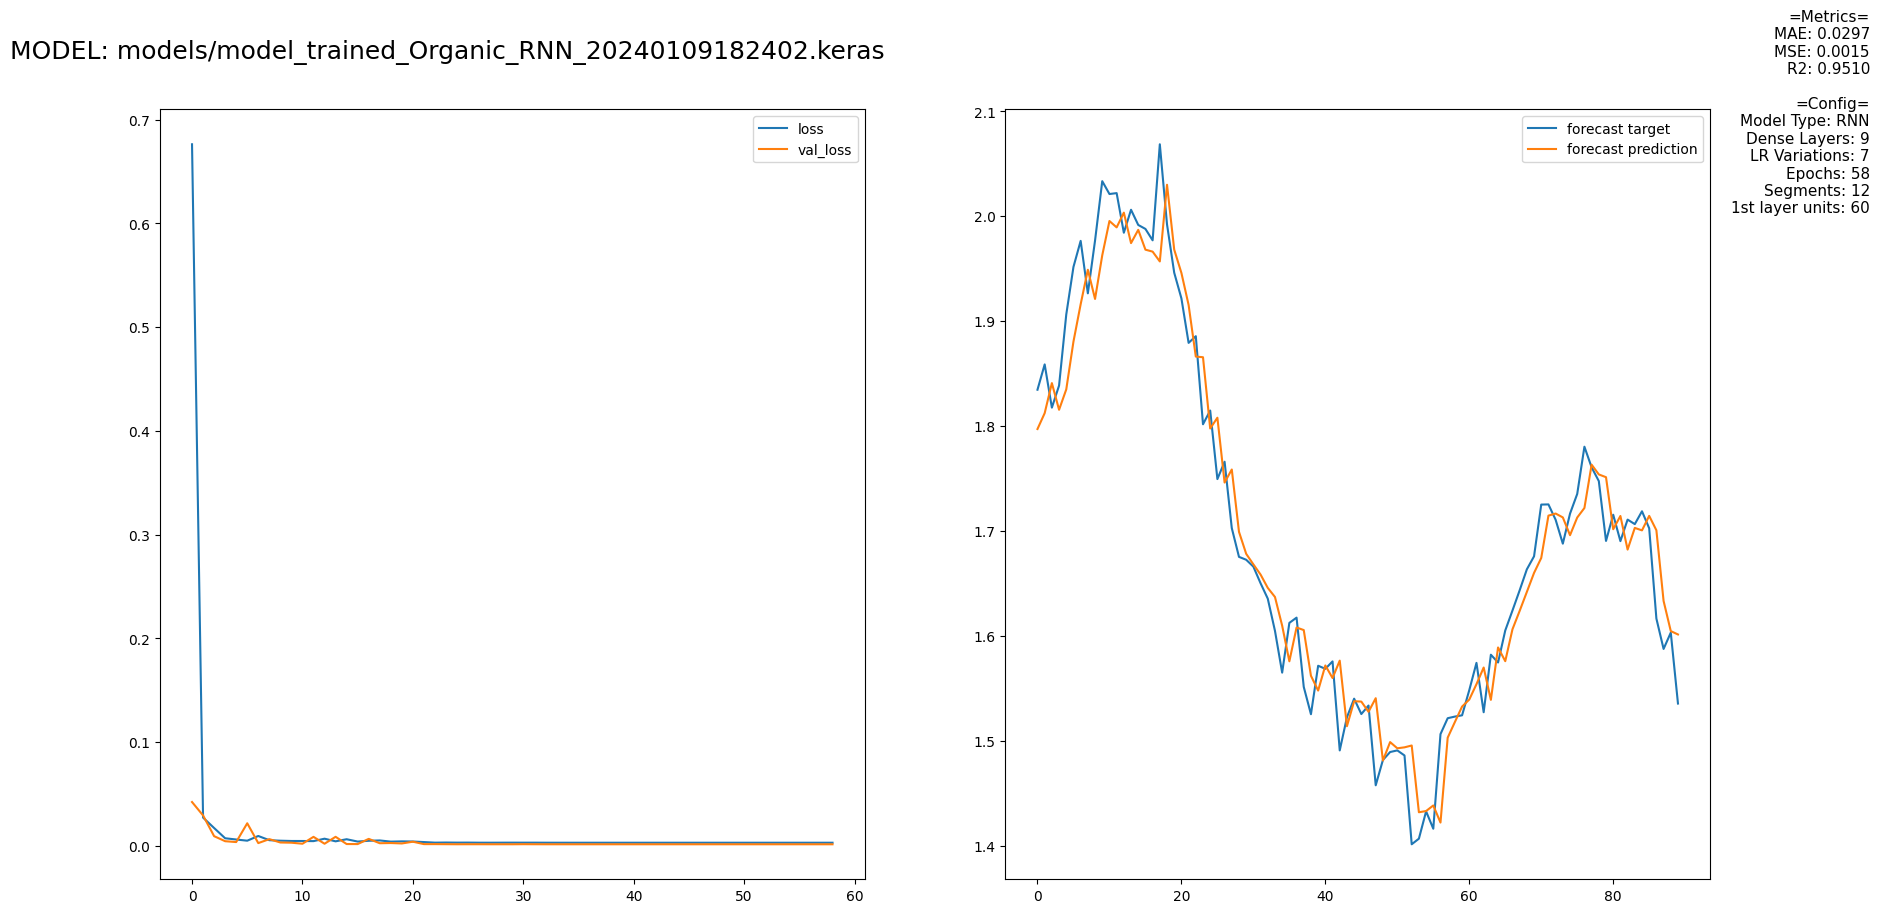

MODEL: models/model_trained_Organic_RNN_20240109183146.keras


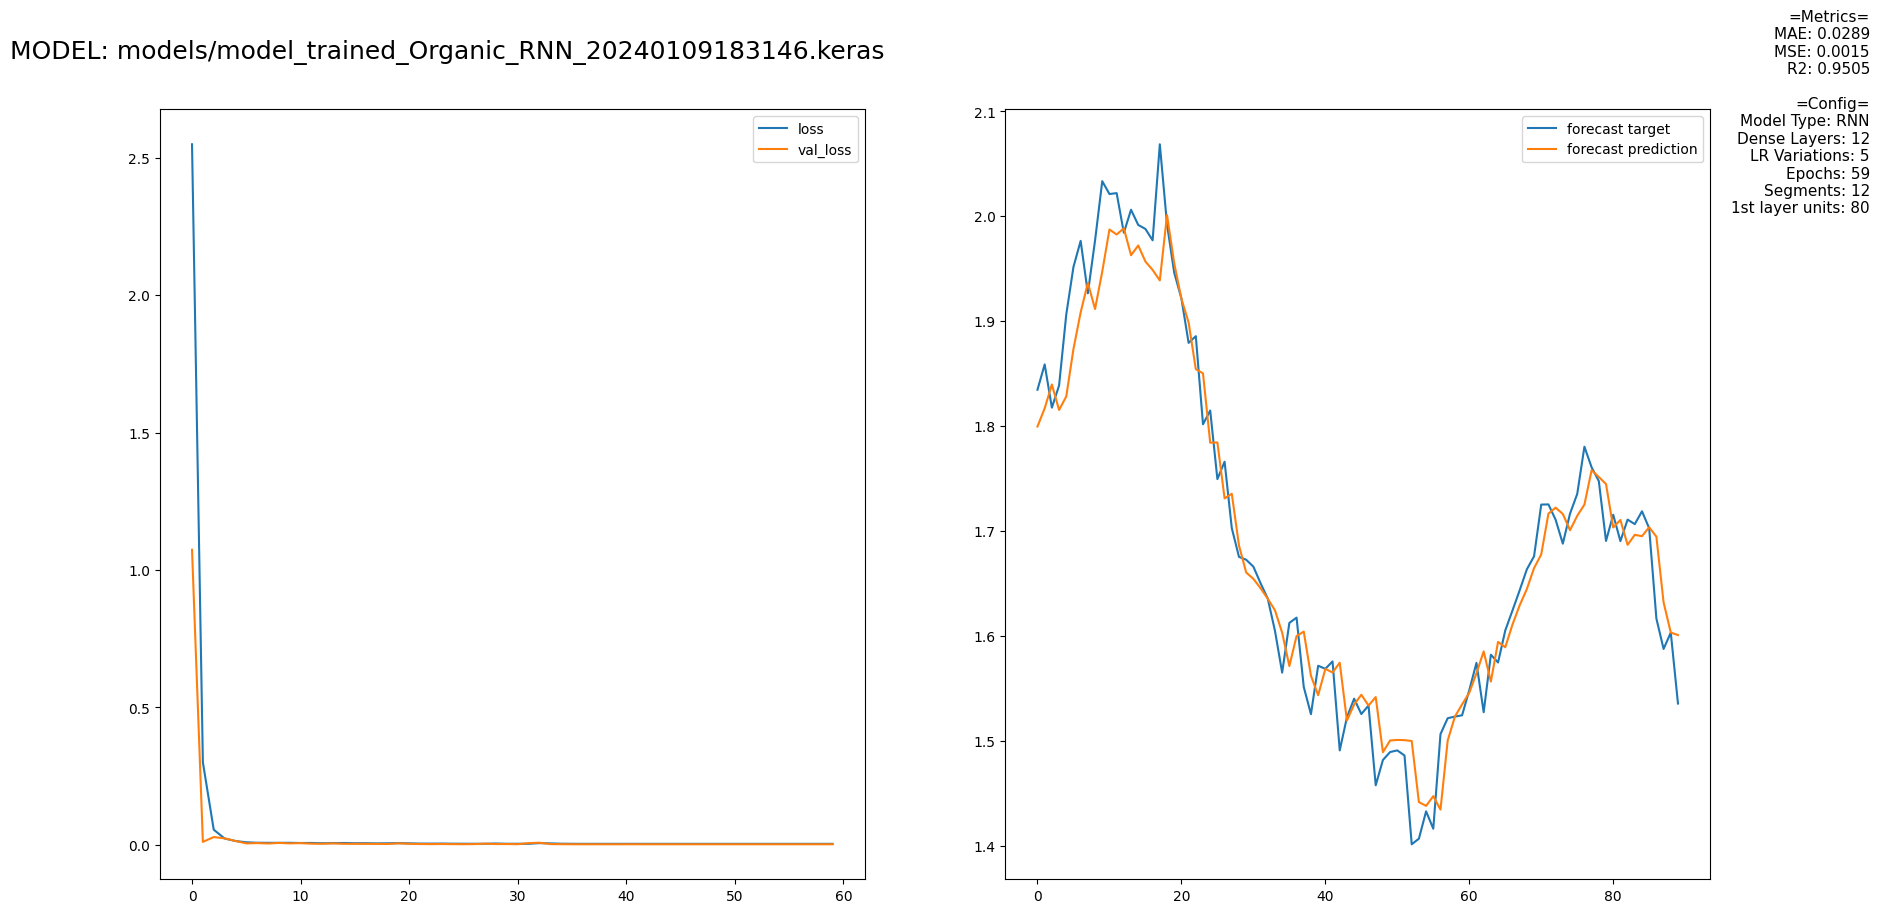

MODEL: models/model_trained_Organic_RNN_20240109181642.keras


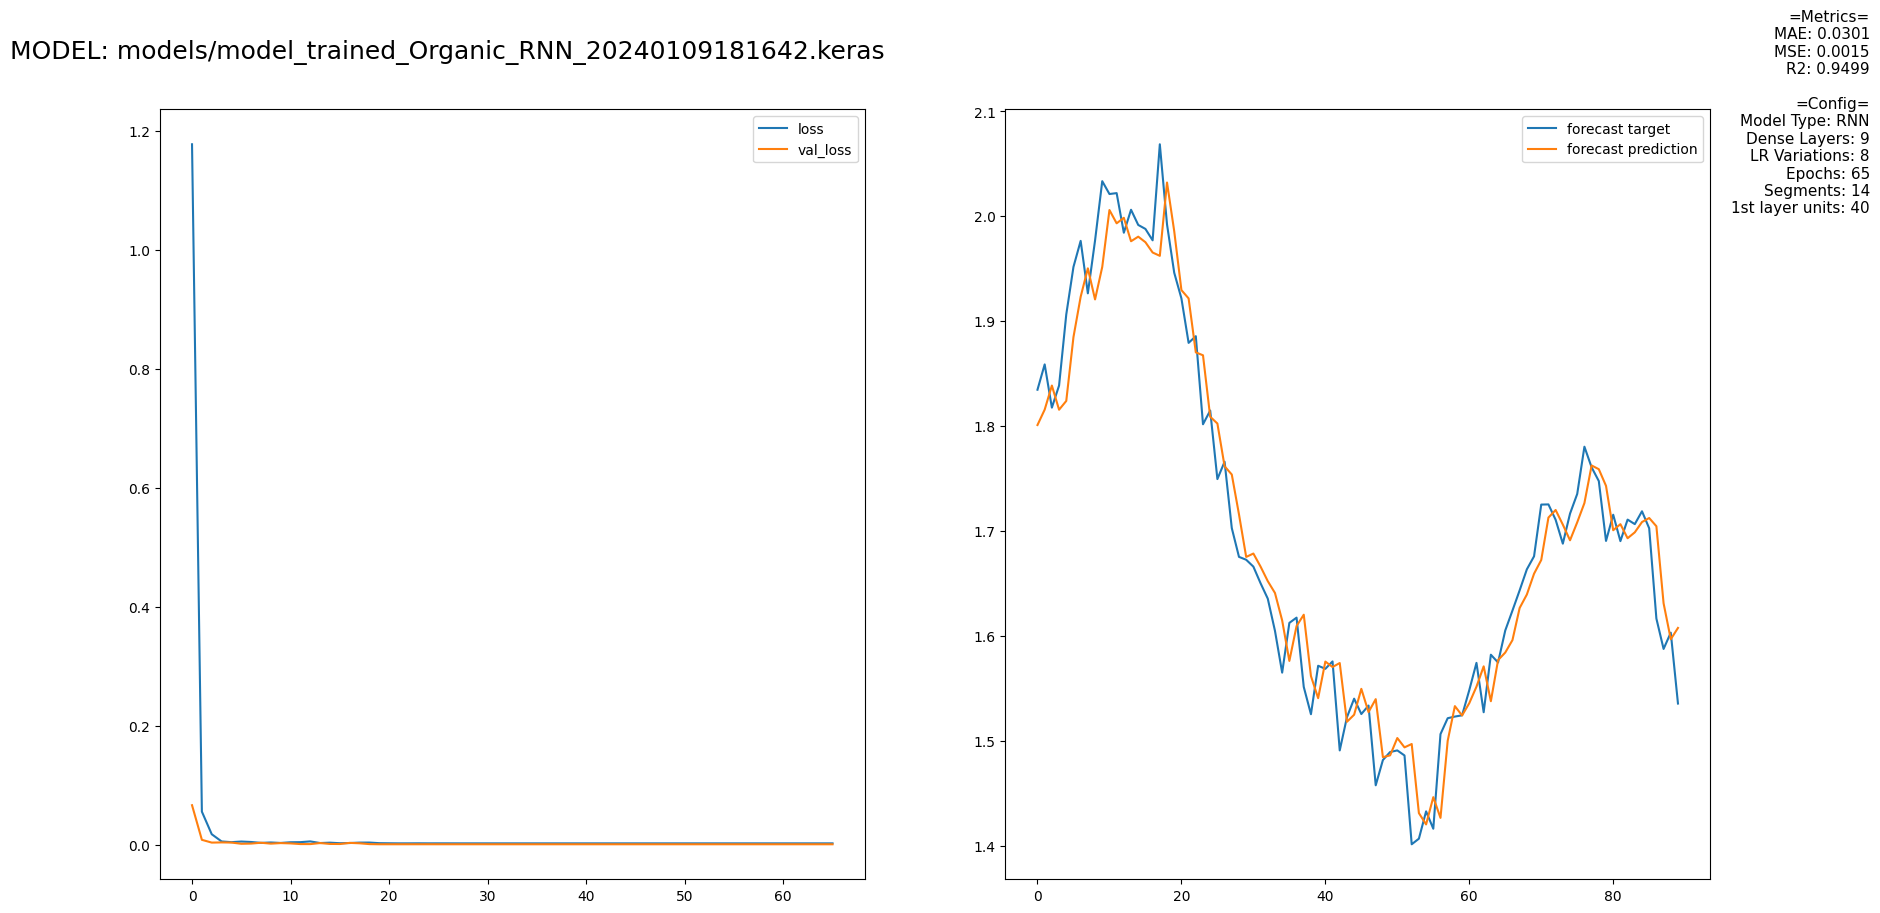


Results for GRU
AVOCADO TYPE: Conventional
MODEL: models/model_trained_Conventional_GRU_20240109135526.keras


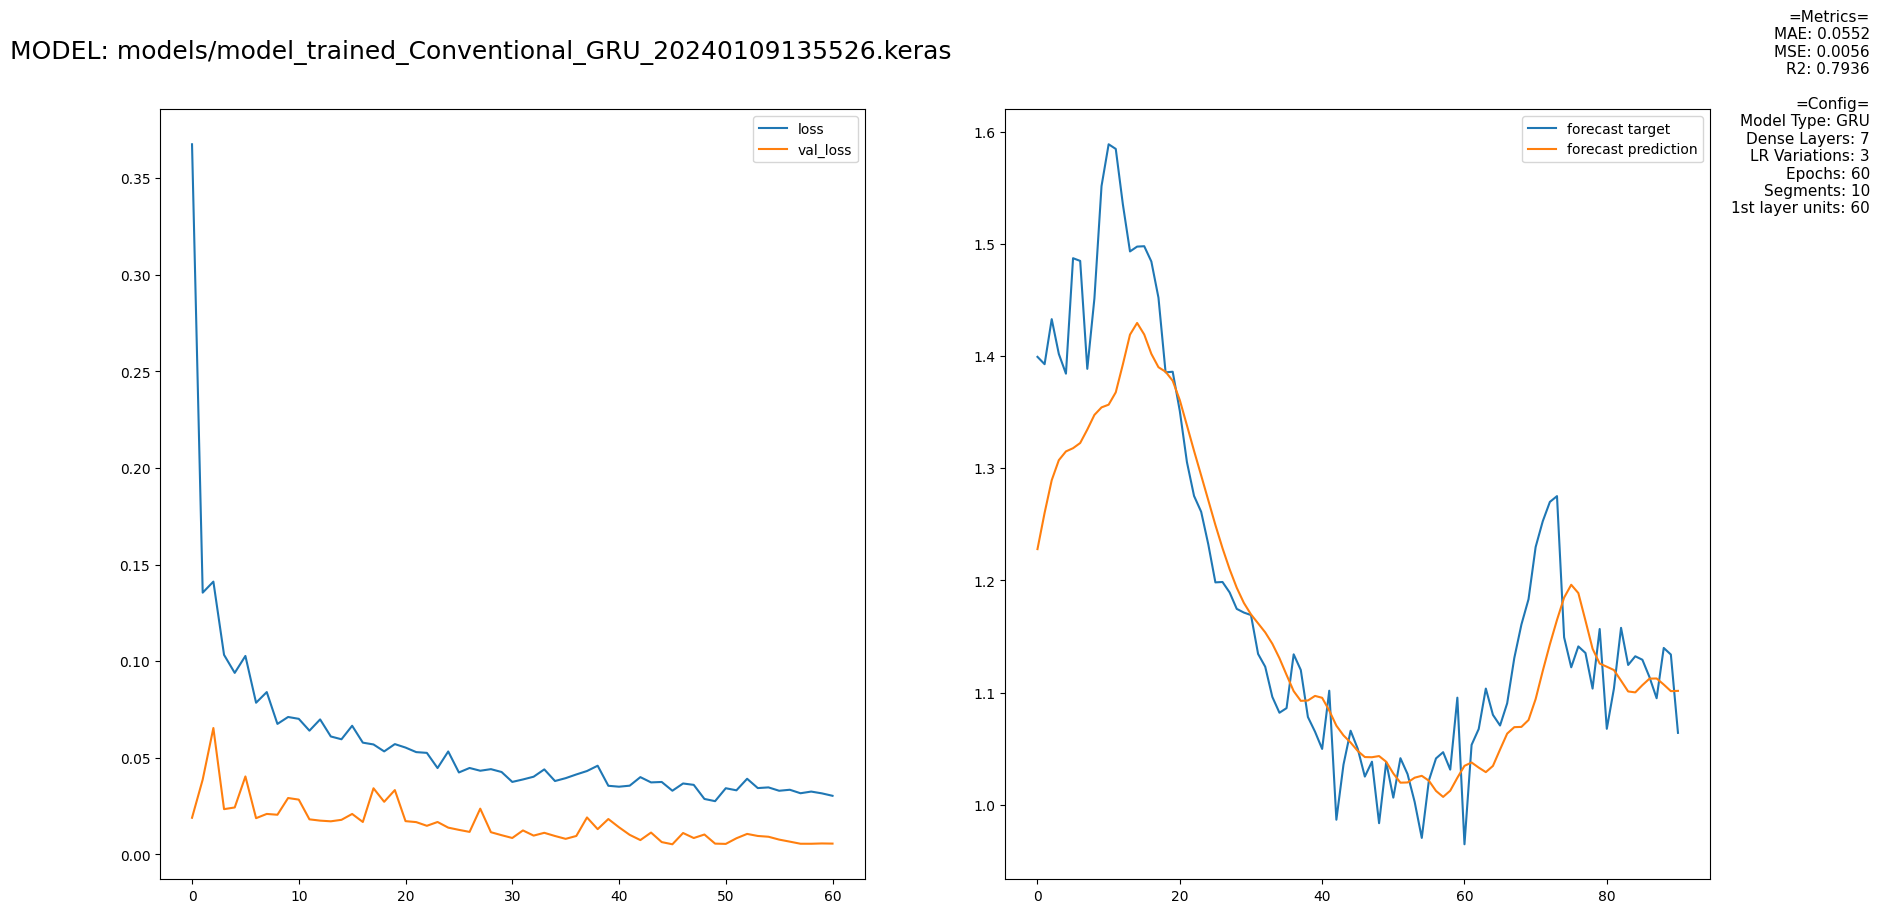

MODEL: models/model_trained_Conventional_GRU_20240109142208.keras


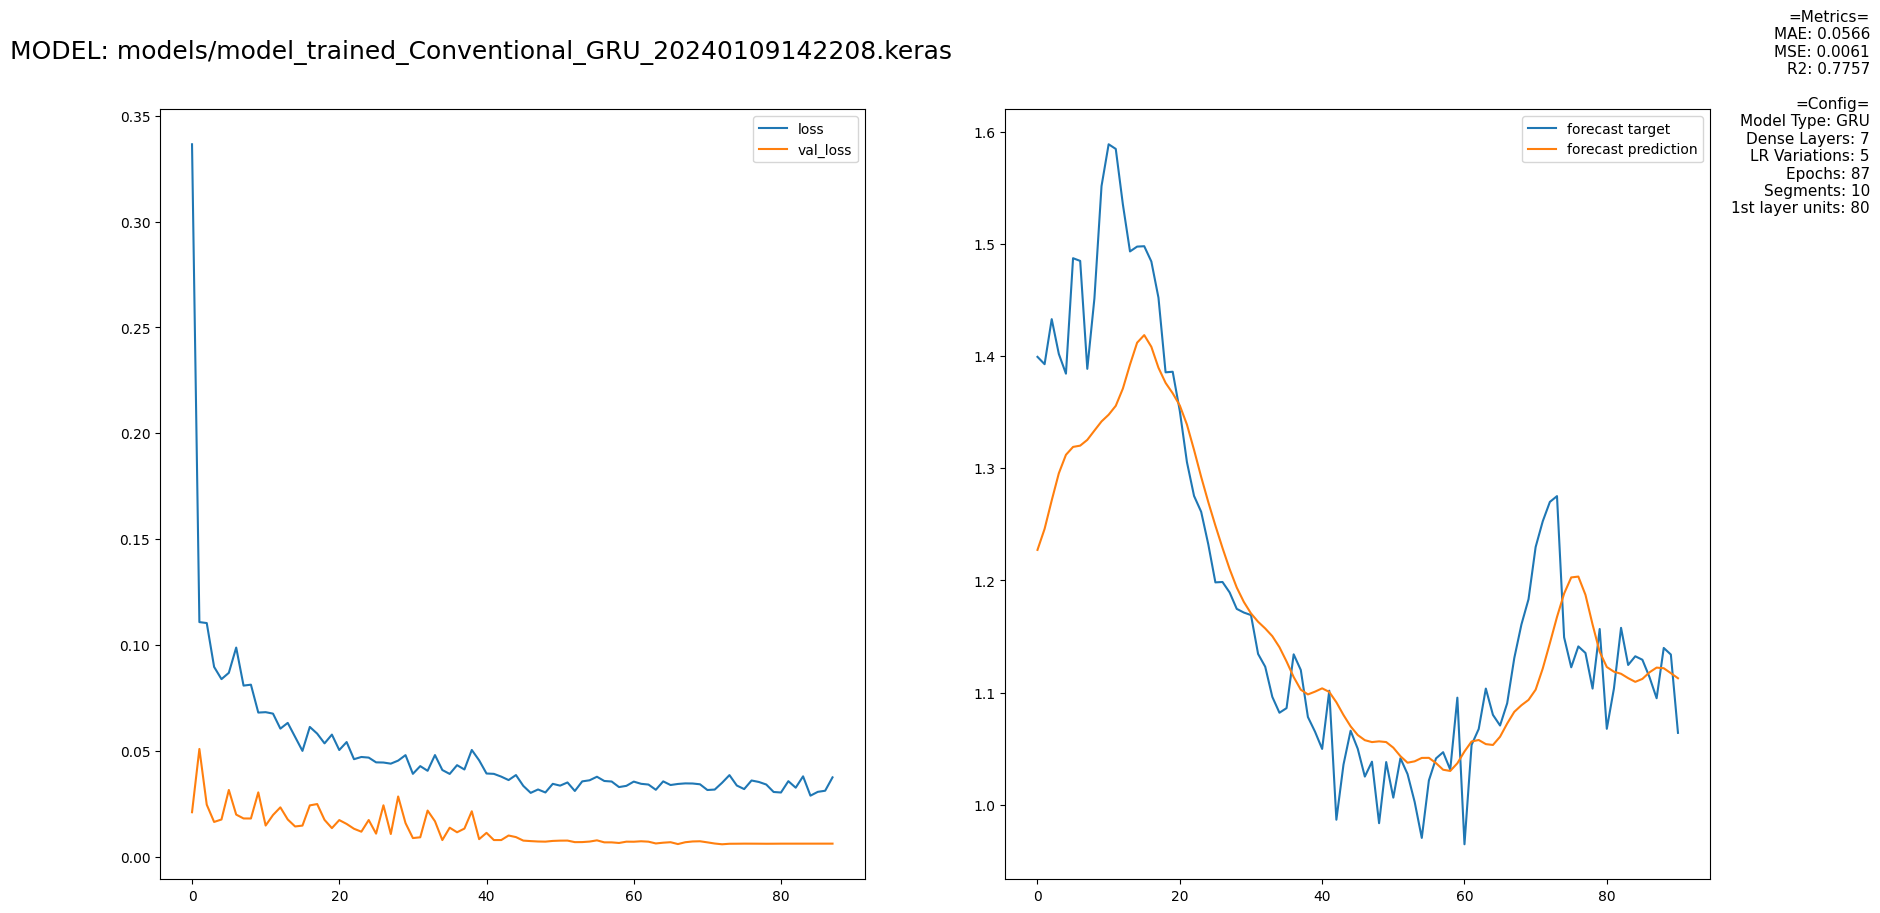

MODEL: models/model_trained_Conventional_GRU_20240109163021.keras


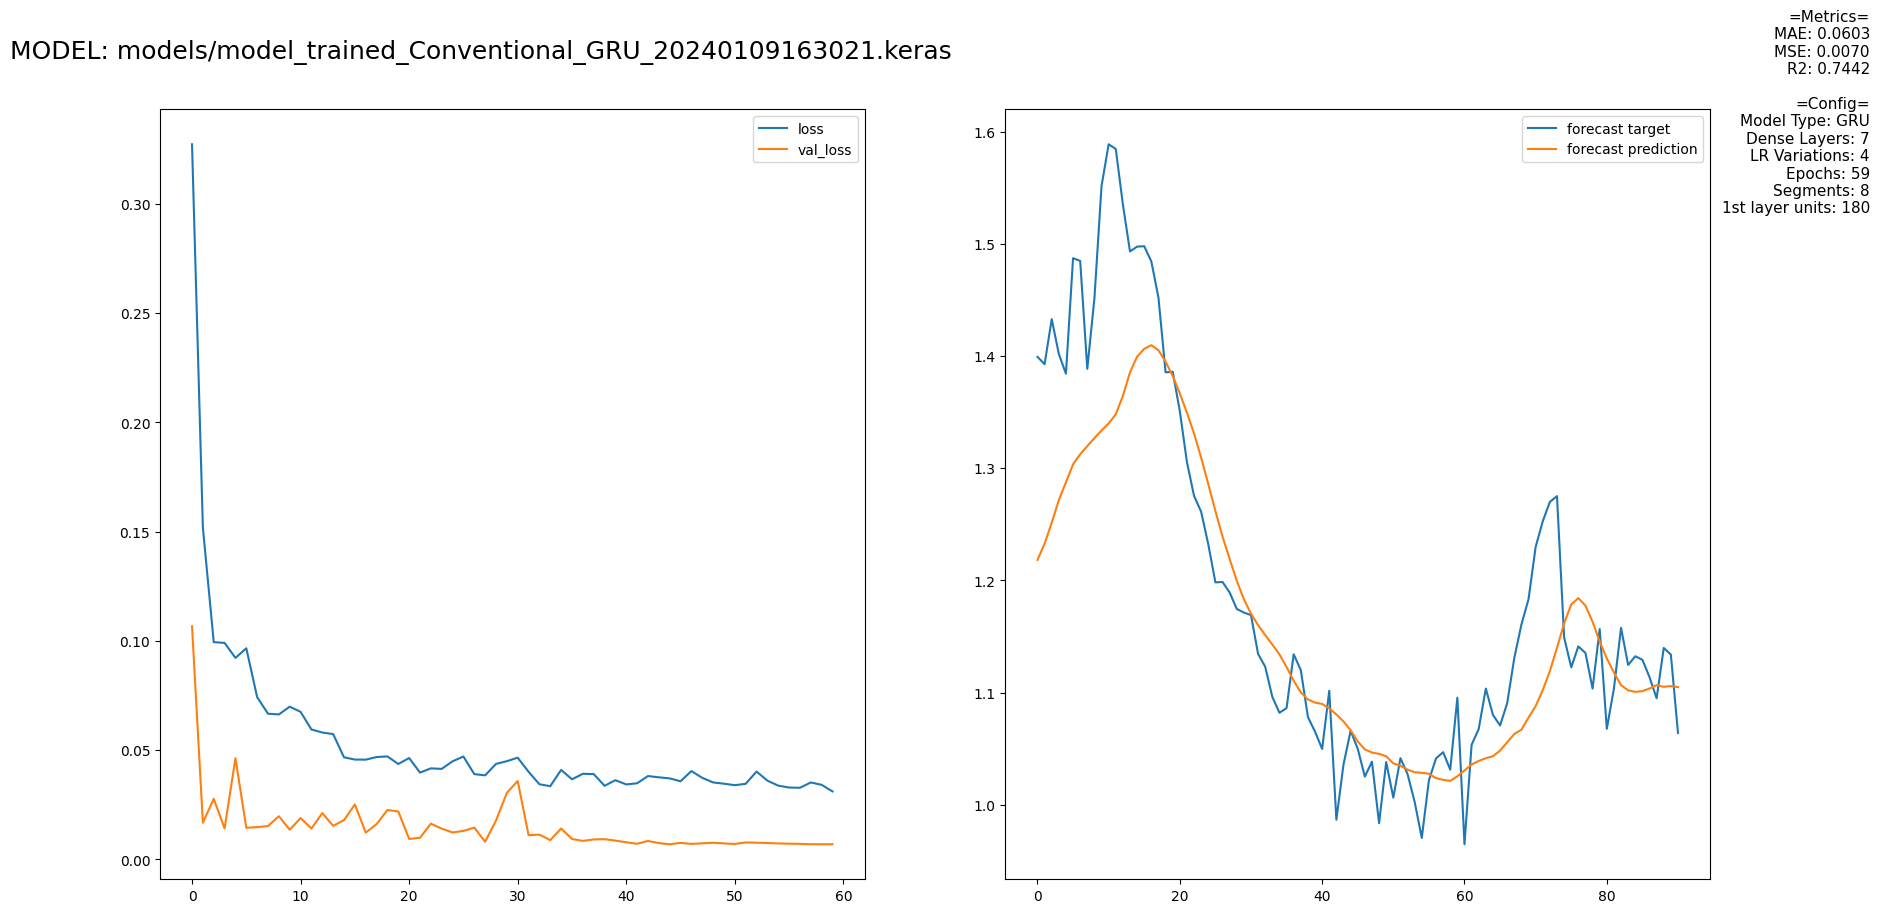

AVOCADO TYPE: Organic
MODEL: models/model_trained_Organic_GRU_20240109190320.keras


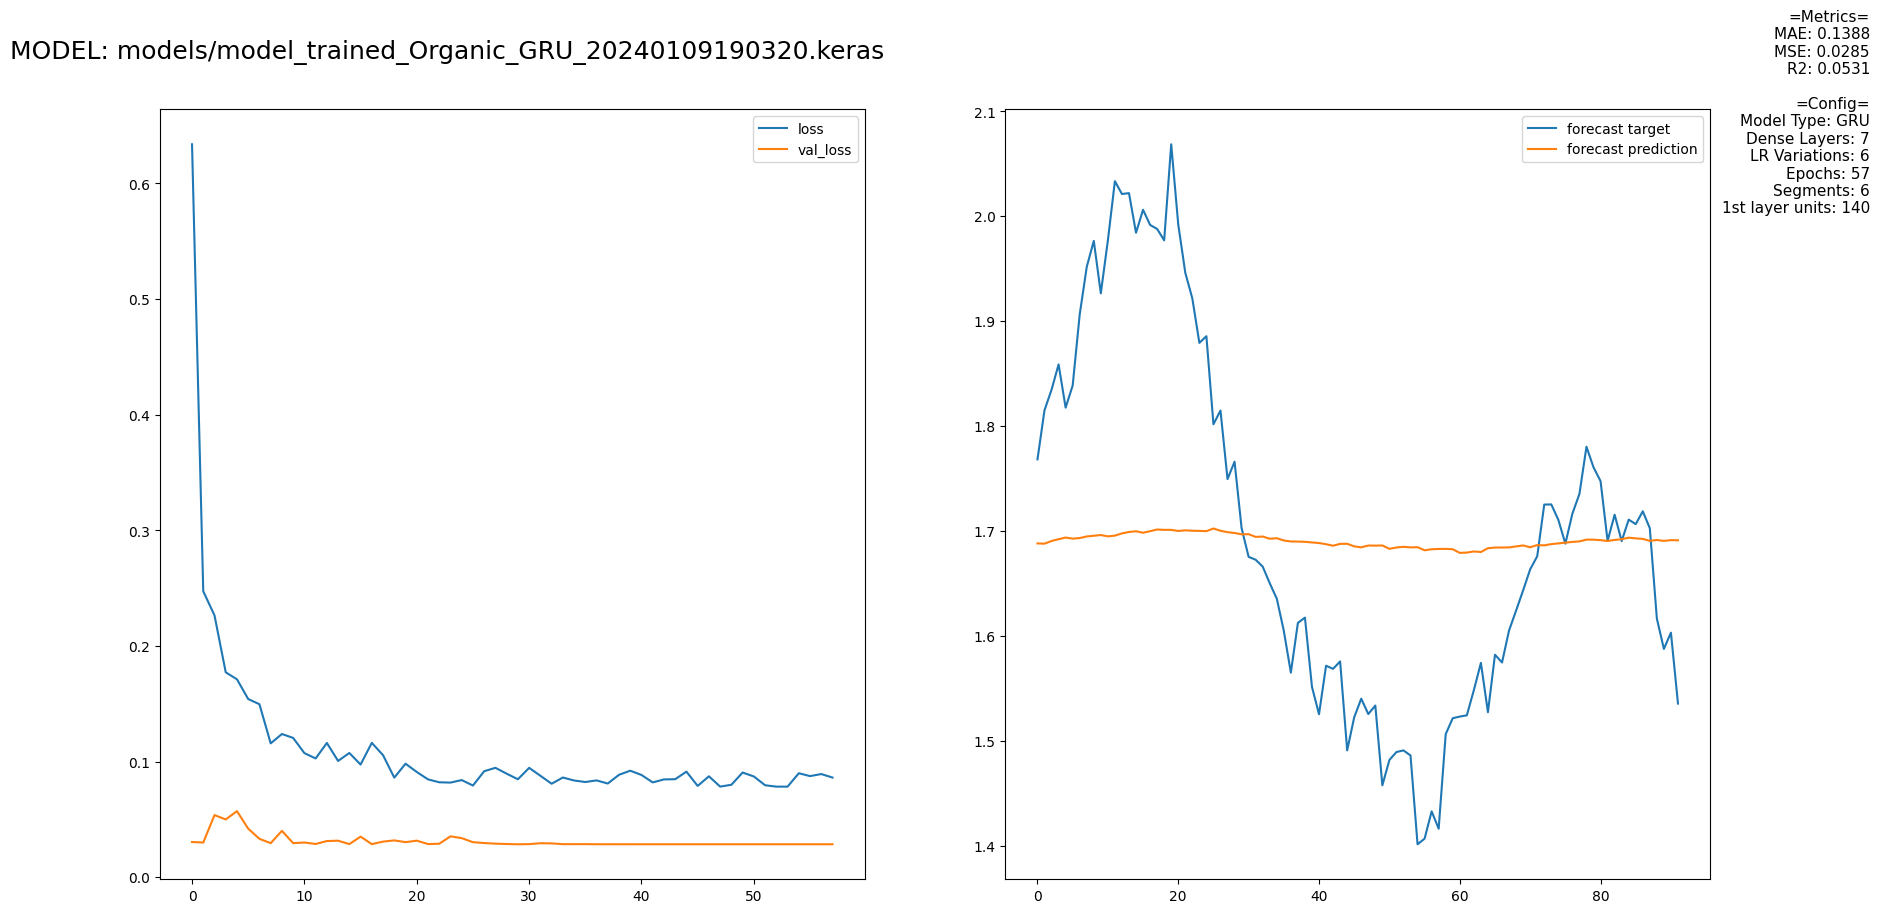

MODEL: models/model_trained_Organic_GRU_20240109171803.keras


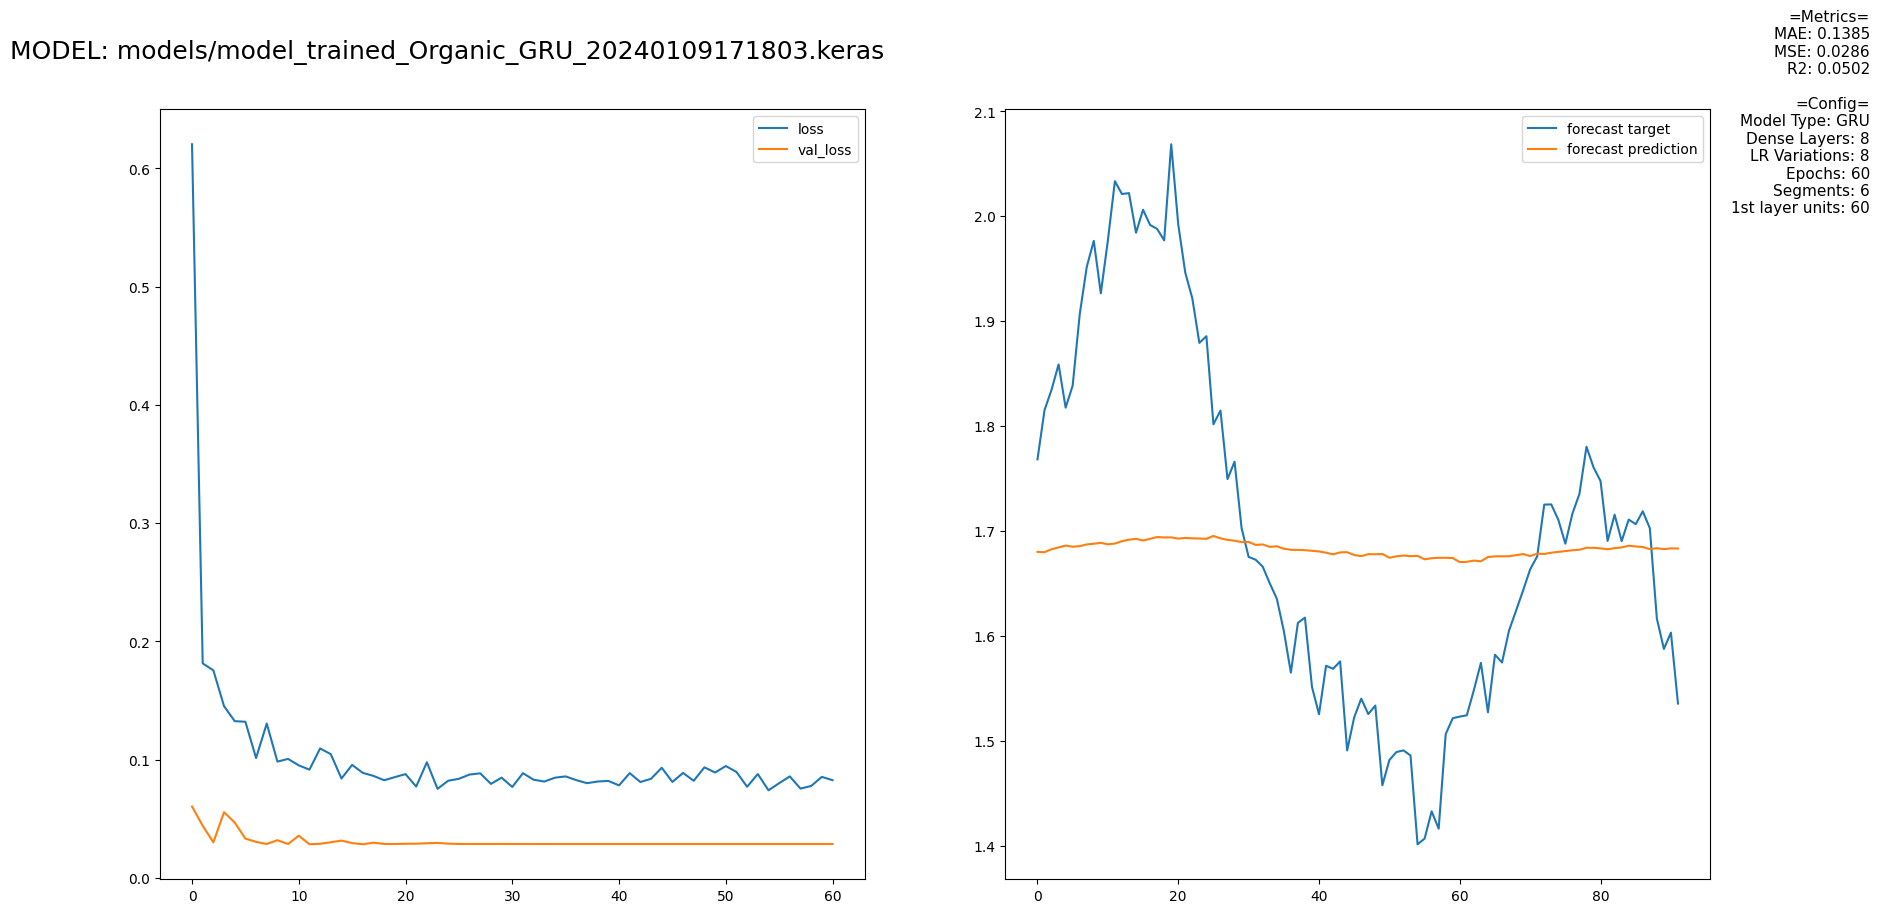

MODEL: models/model_trained_Organic_GRU_20240109190148.keras


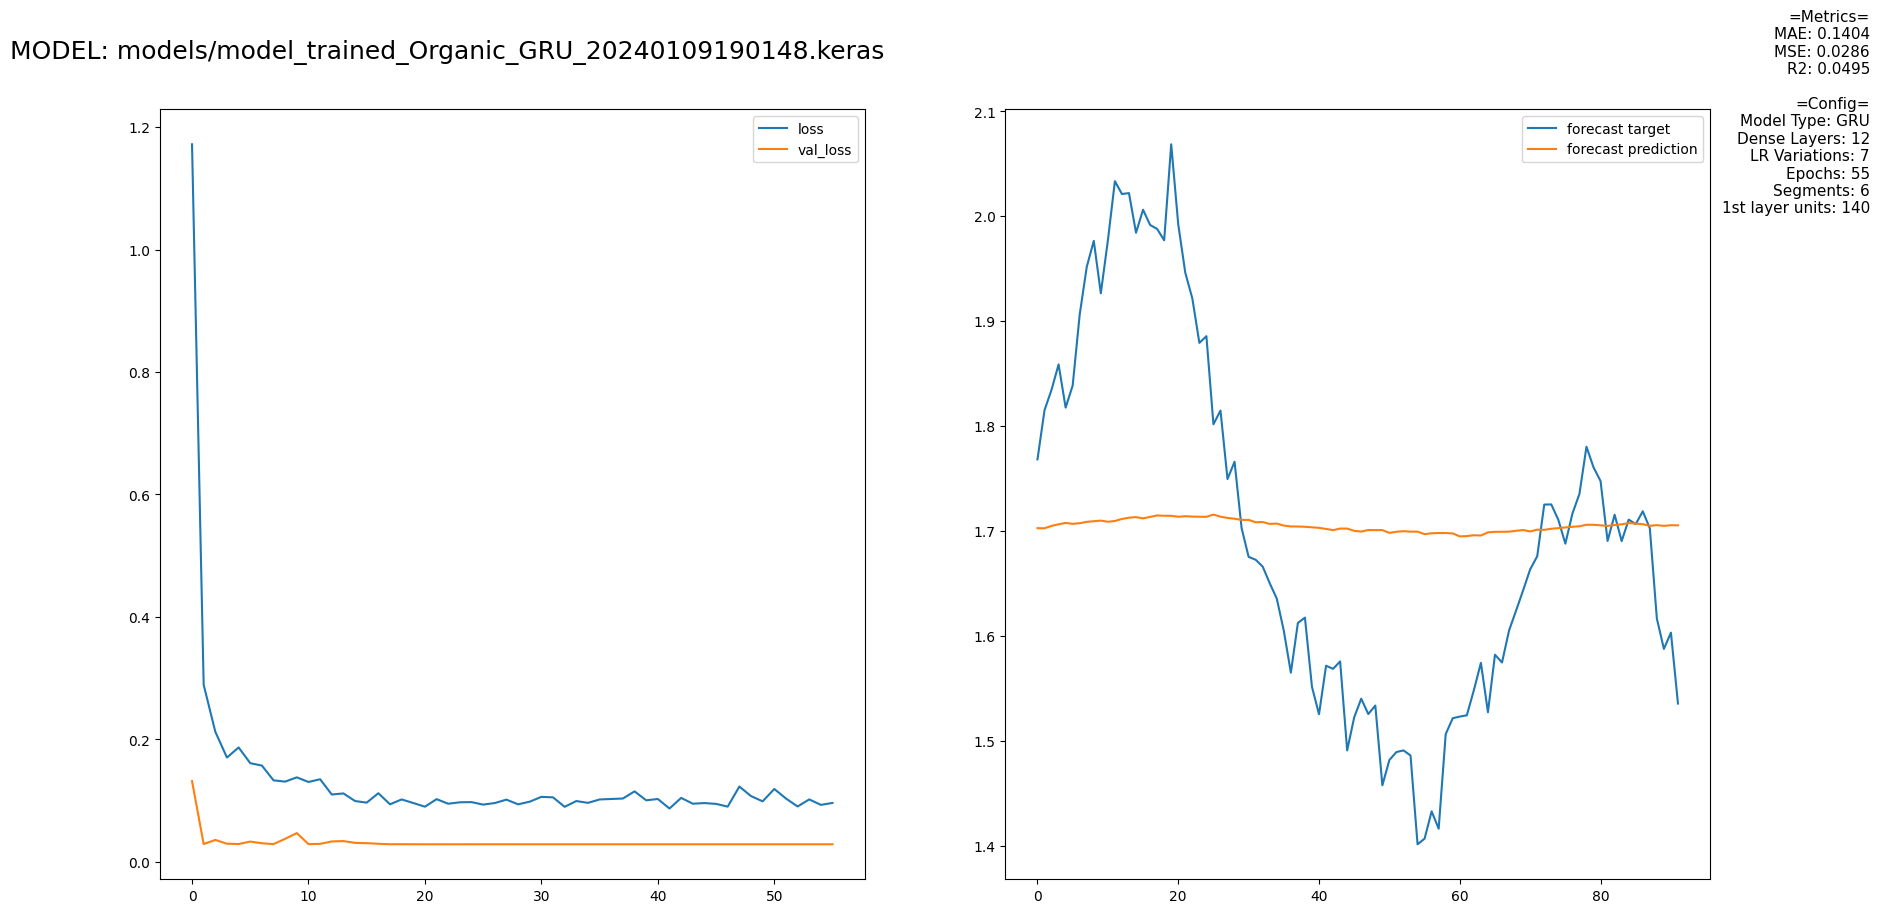


Results for LSTM
AVOCADO TYPE: Conventional
MODEL: models/model_trained_Conventional_LSTM_20240110133740.keras


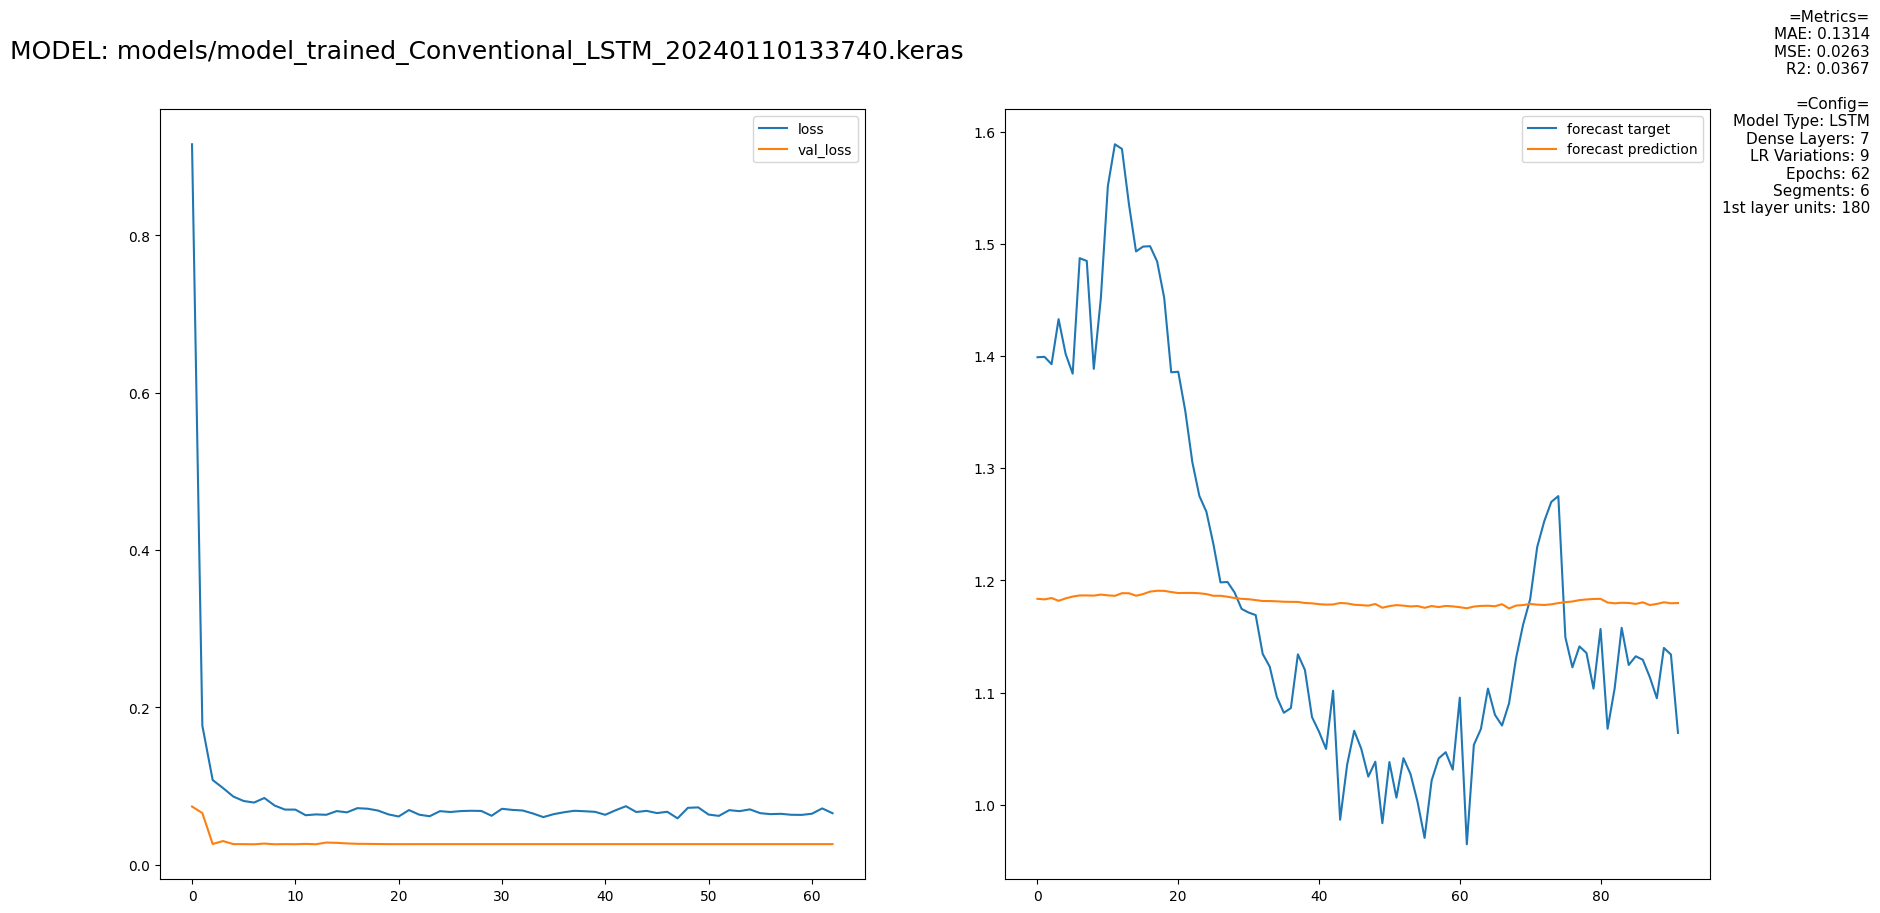

MODEL: models/model_trained_Conventional_LSTM_20240110130740.keras


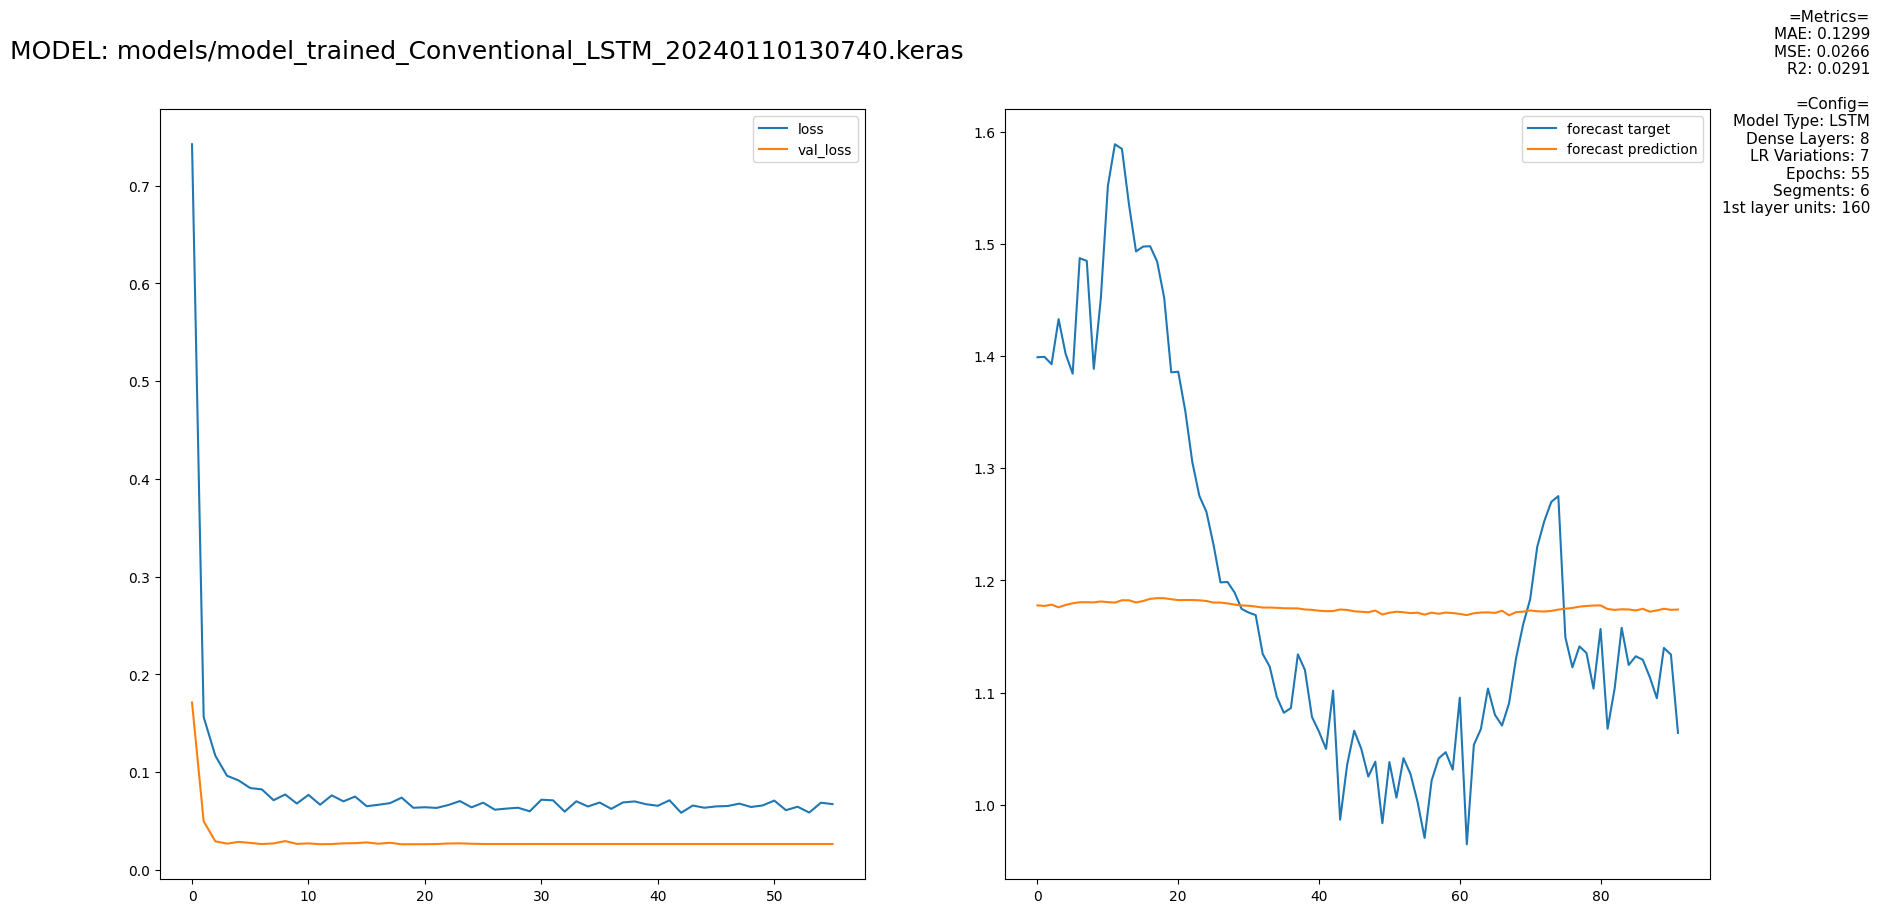

MODEL: models/model_trained_Conventional_LSTM_20240110130656.keras


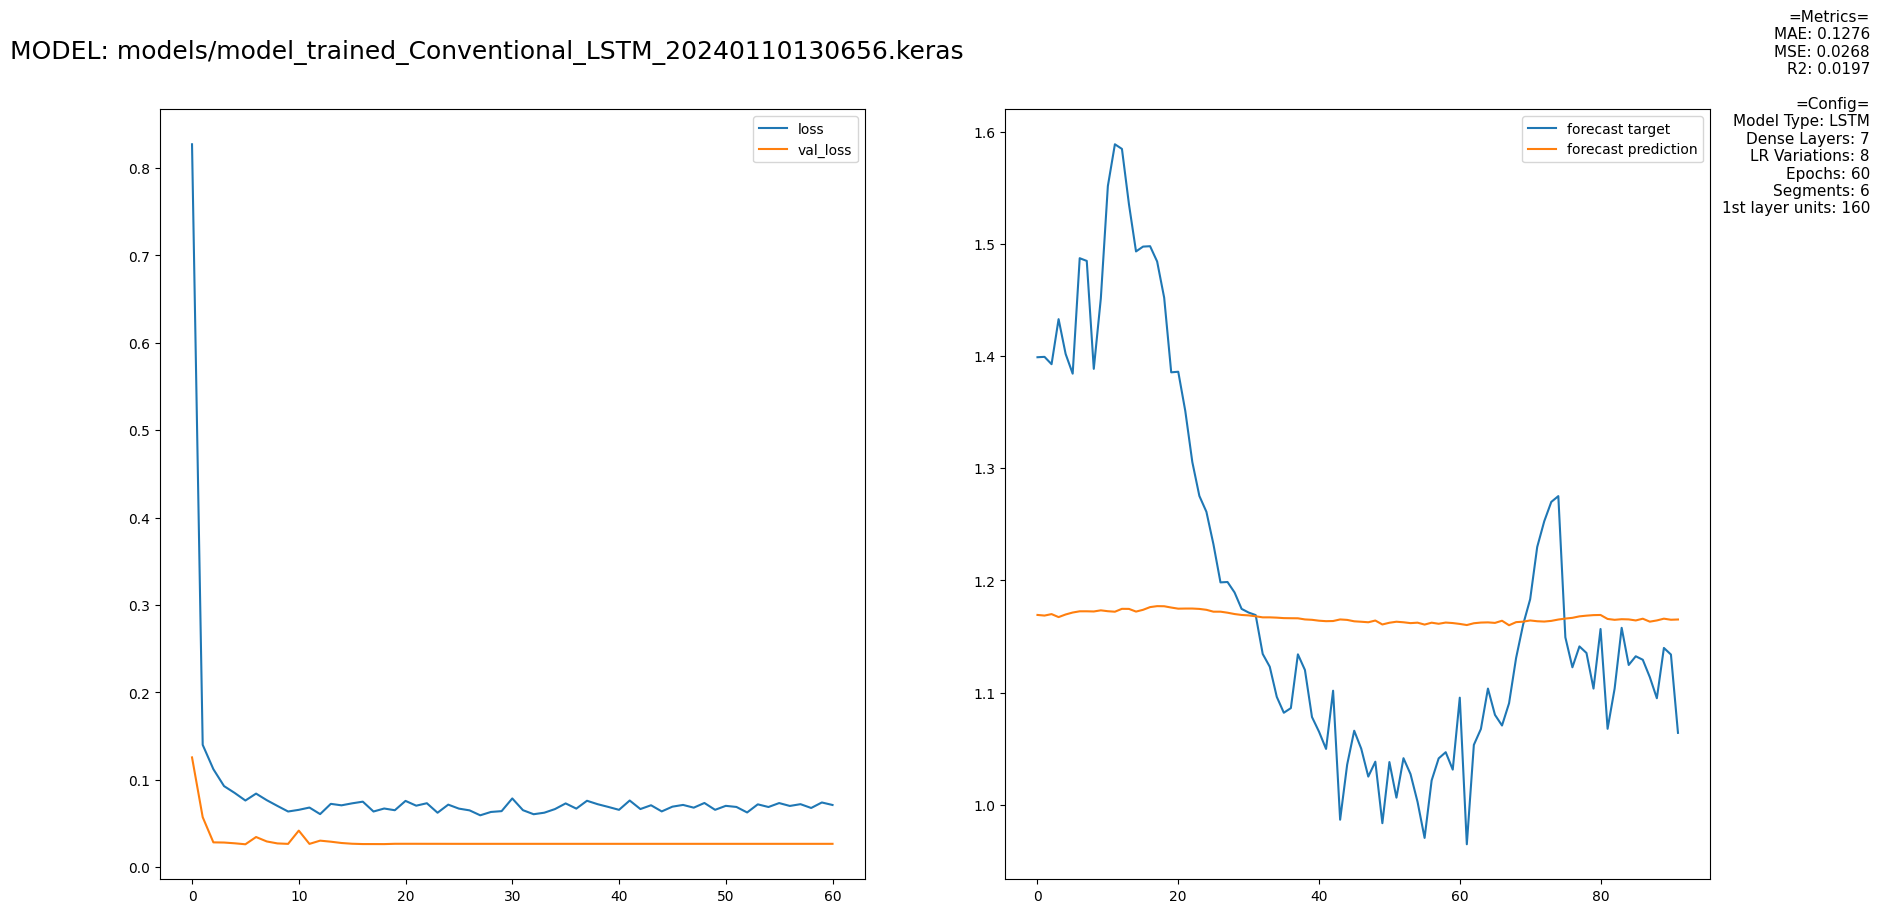

AVOCADO TYPE: Organic
MODEL: models/model_trained_Organic_LSTM_20240110195245.keras


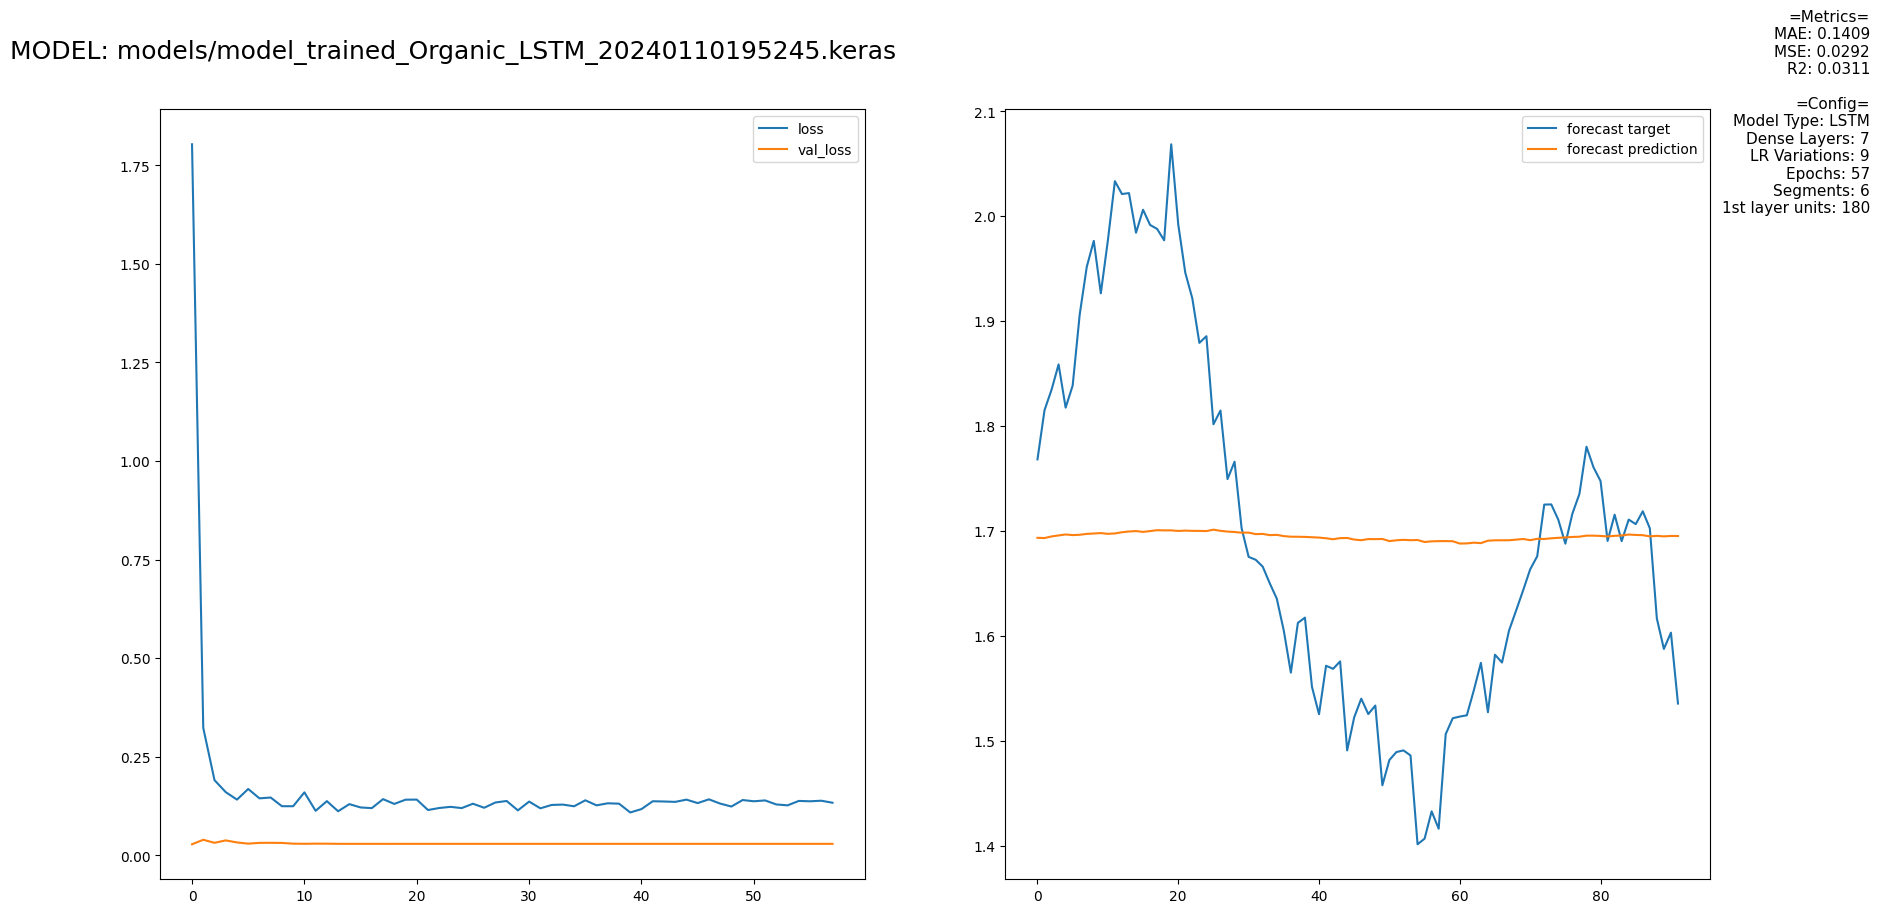

MODEL: models/model_trained_Organic_LSTM_20240110174401.keras


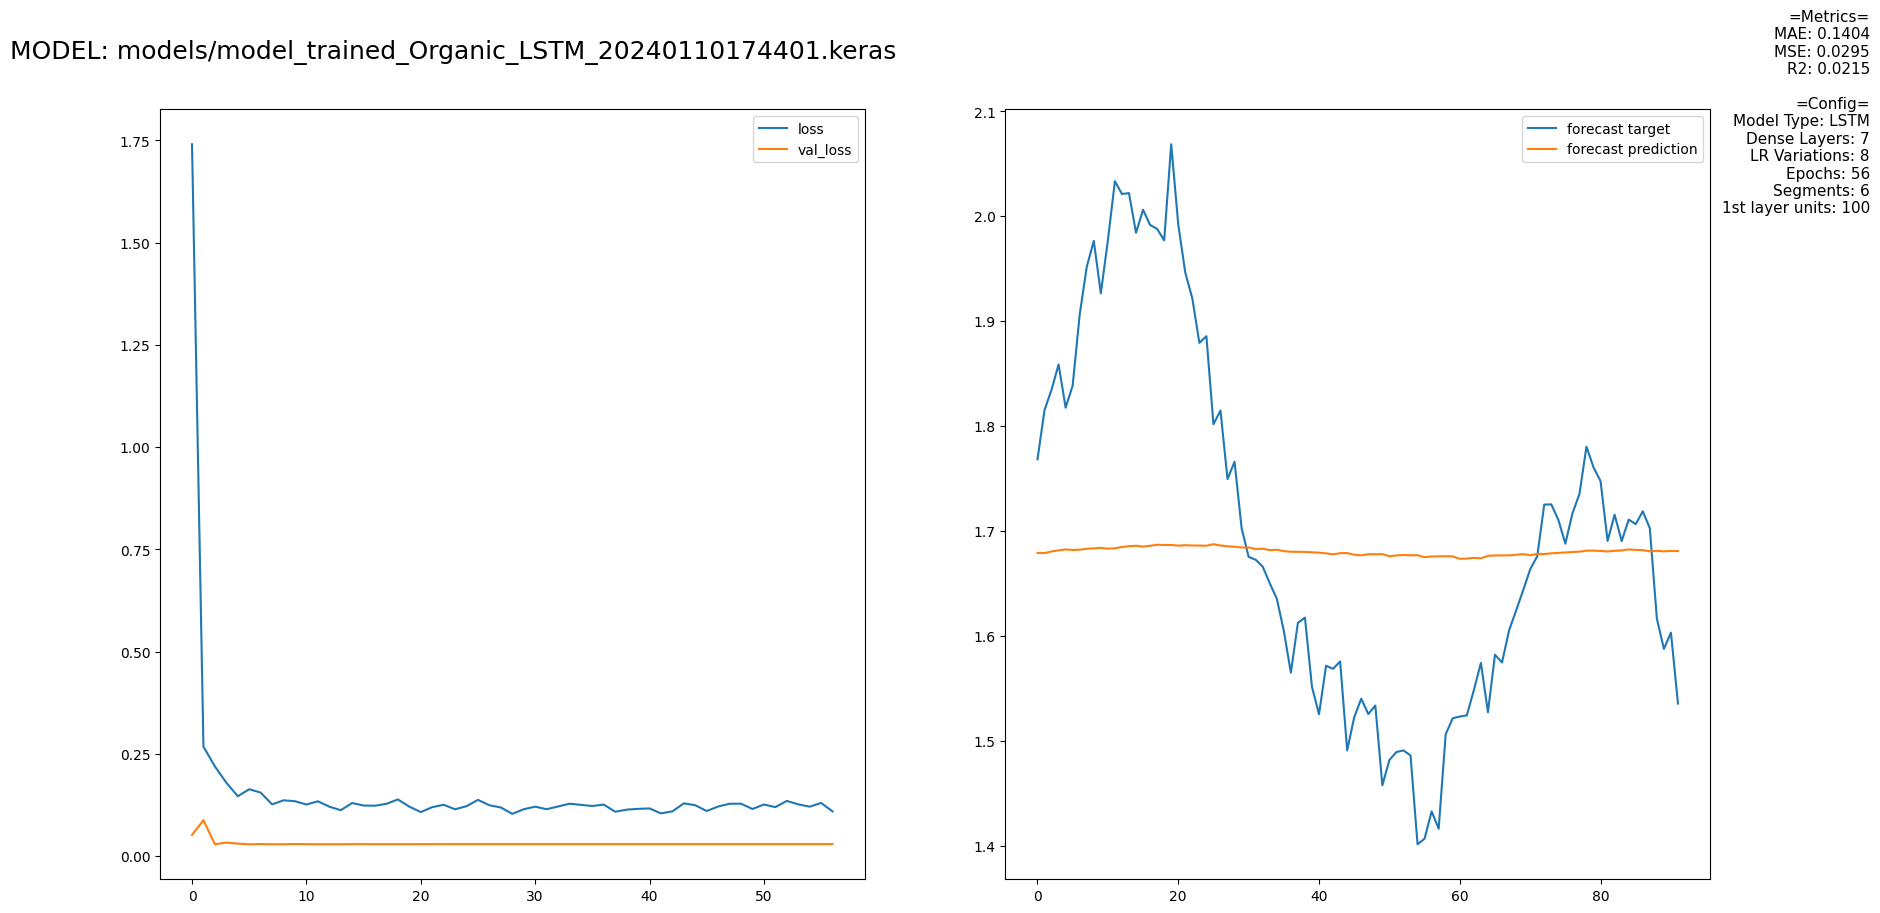

MODEL: models/model_trained_Organic_LSTM_20240110195141.keras


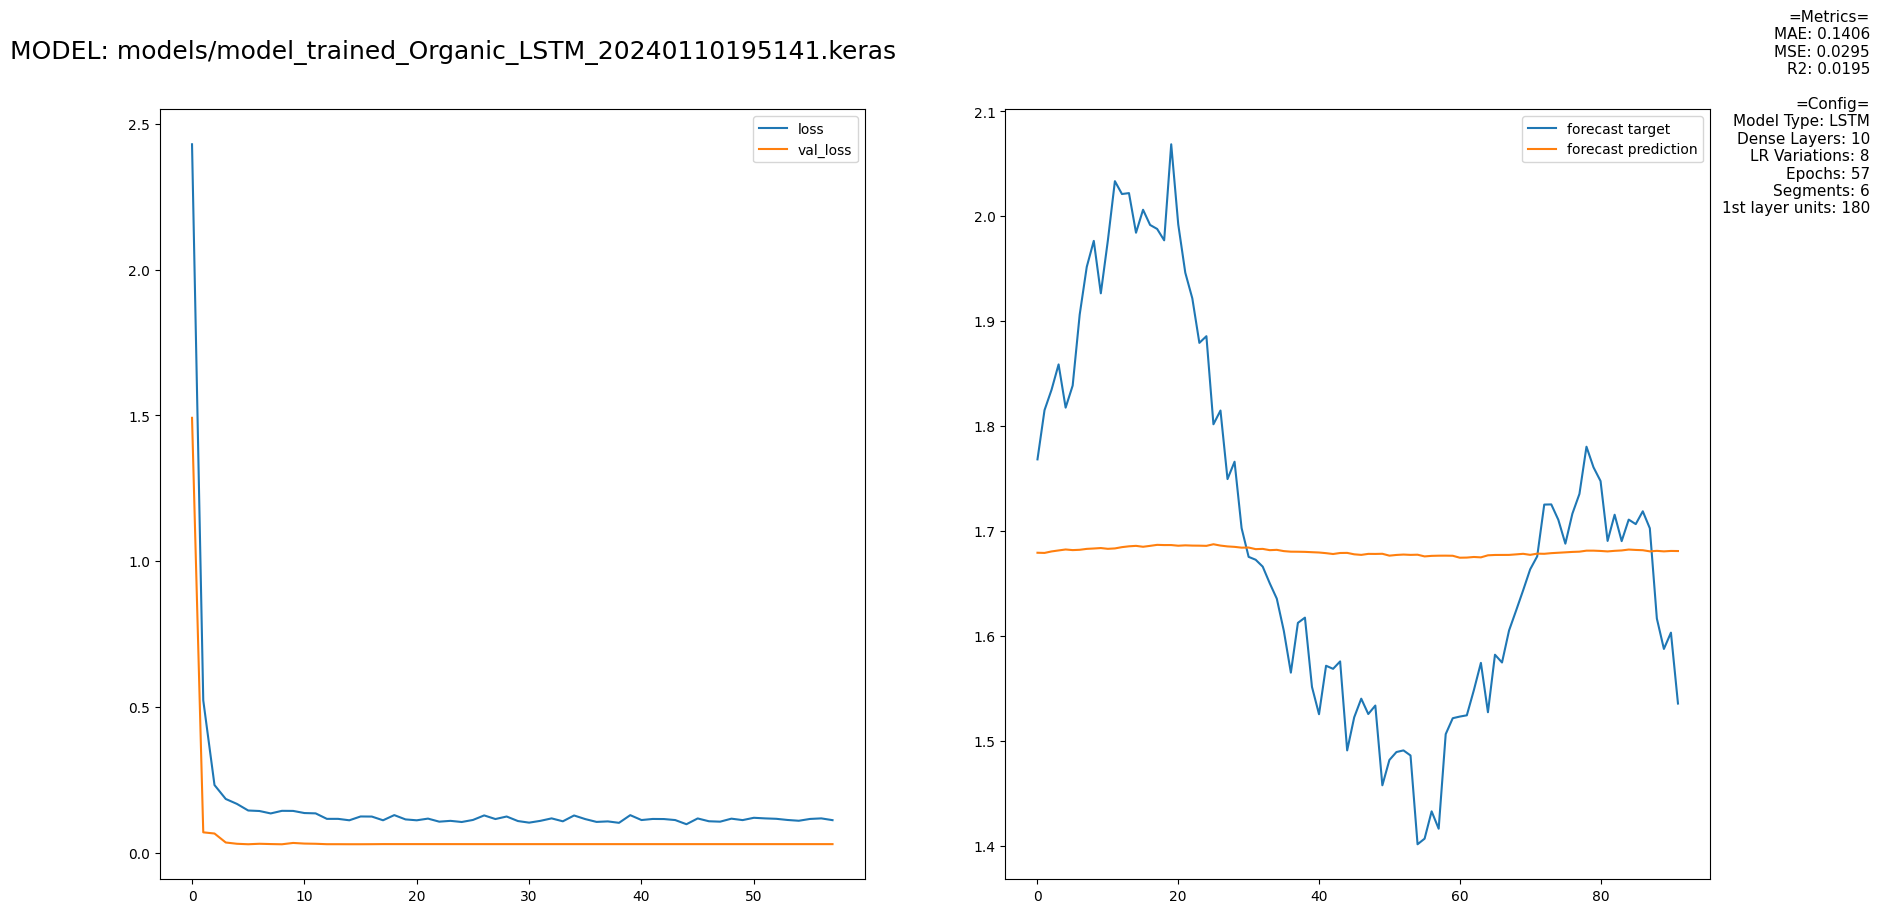

In [10]:
for model_type in model_types:
    print()
    print(f"Results for {model_type}")
    data = model_results_df[model_results_df["model_type"] == model_type]
    for avocado_type in avocado_types:
        print(f"AVOCADO TYPE: {avocado_type}")
        filtered_data = data[data["avocado_type"] == avocado_type]
        filtered_data = filtered_data.sort_values("R2", ascending = False).head(3)
        get_results(filtered_data)